# Mini-project 1: Deep Q-learning for Epidemic Mitigation

### Authors : Mohamed Hichem hadhri, Yassine Chaouch

###  Imports

In [41]:

import random
import math

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent
from gym import spaces

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
from collections import namedtuple

"""Plotting imports"""
import matplotlib.pyplot as plt
import pickle

""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

In [42]:
SCALE = 100

ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

##### Helper functions

In [43]:
def parse_logs(dyn, log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return total,cities,actions



def plot_info(total, cities, actions, action_plot=True):
    """ Plot the results """
    from matplotlib.ticker import MultipleLocator

    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    if action_plot:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if action_plot:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')


    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()


def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title or 'beds' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)


In [44]:

def action_preprocessor(a: torch.Tensor, dyn:ModelDynamics):
    """Action preprocessor"""
    action = { # DO NOTHING
            'confinement': False, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,
        }

    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True

    return action
        
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    """Observation preprocessor"""
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    # compute power 1/4 of the infected
    infected = np.power(infected, 1/4)

    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # compute power 1/4 of the dead
    dead = np.power(dead, 1/4)
    
    return torch.Tensor(np.stack((dead, infected))).unsqueeze(0)


def observation_preprocessor_action(obs: Observation, dyn:ModelDynamics):
    """Observation preprocessor with last_action added to the state"""

    _res = torch.flatten(observation_preprocessor(obs, dyn).squeeze(0))

    # get last action (TODO : extract directly from dyn.get_action()
    action = [int(obs.action['confinement']), int(obs.action['isolation']), int(obs.action['hospital']),int(obs.action['vaccinate'])]

    # concat res and action 
    return torch.cat((_res, torch.Tensor(action))).unsqueeze(0)
    

# Define the transition tuple to be stored in MemoryPlayer in part 3 and 4
Transition = namedtuple('Transition',
                    ('state', 'action', 'next_state', 'reward'))


### 1. Introduction

#### Question 1.a) study the behavior of the model when epidemics are unmitigated

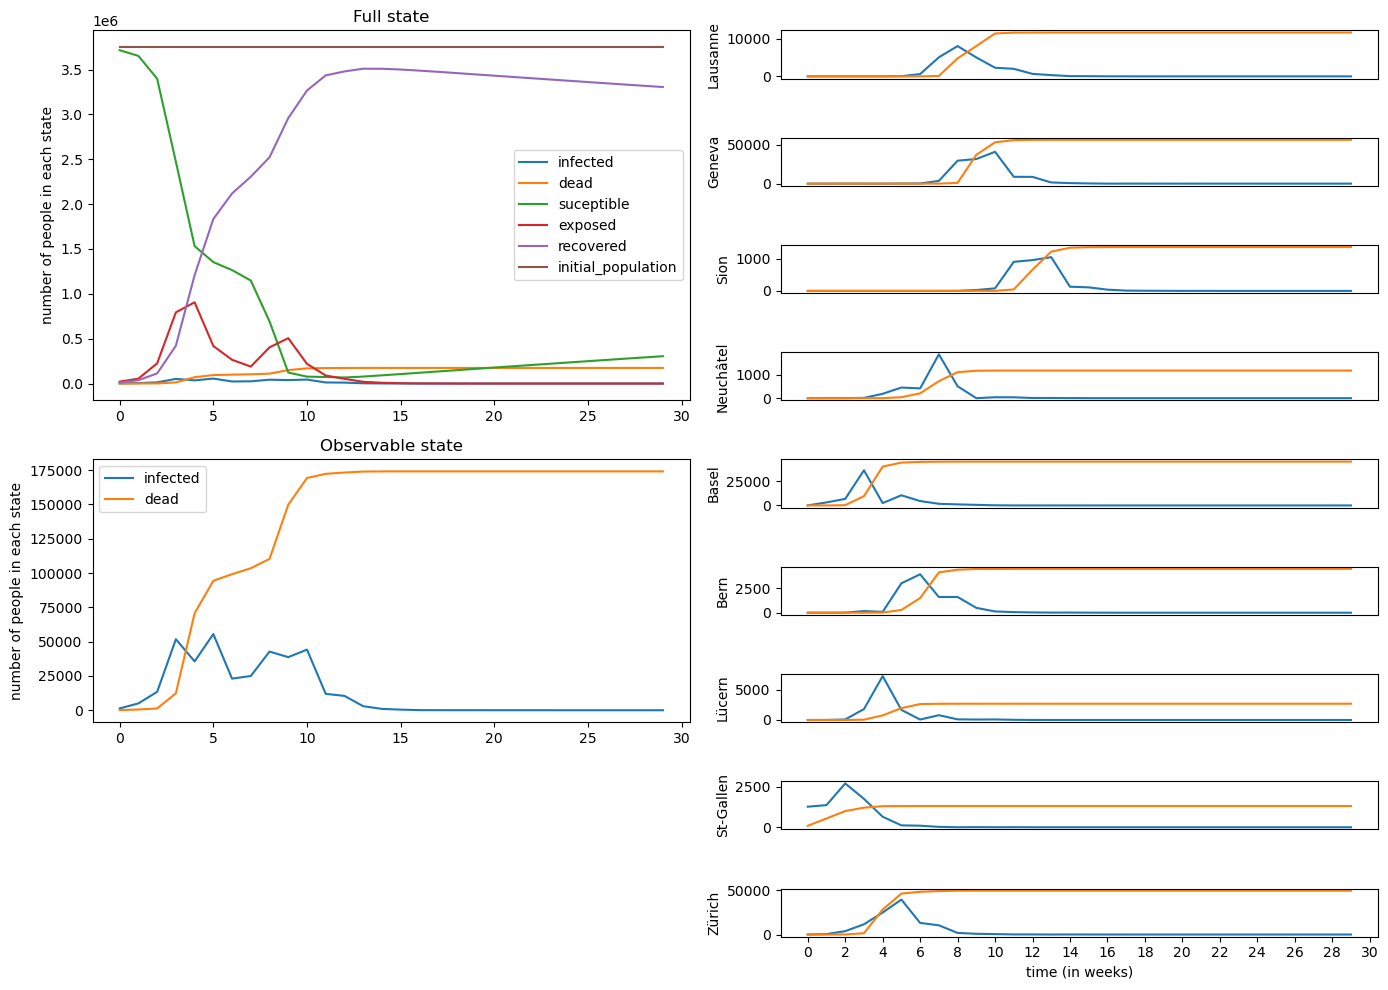

In [45]:
# load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml') 

# create environment
env = Env(dyn, action_space=None, observation_space=None) 

# DO NOTHING
action = { 
    'confinement': False, 
    'isolation': False, 
    'hospital': False, 
    'vaccinate': False,
}


""" Run the simulations, seeded"""
log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities,actions, action_plot=False)

**Discussion :**

From the results above, we can clearly see the rate of mortality is high, e.g the number of deaths increases explonentially at the first 15 weeks, and the it converges slowly to a maximum. Moreover, the number of Infected people increases exponentially at first and then it stabilizes for some weeks until it drops qucikly to zero. This can be explained that infected people can turn to either dead or recovered and at the end all the population is either dead or recovered. <br>

Fron the results of each city, we can observe a trend. The number of infected people peaks around 4 to 6 weeks, followed by an increaed rate of mortality, This is due to the absence of actions to reduce the rate of spread and the rate of mortality like Isolation and hospitality <br>

### 2. Professor Russo’s Policy

**Question 2.a)** Implement Pr. Russo’s Policy

In [88]:
from epidemic_env.agent import Agent
from epidemic_env.env import Env


class Russo(Agent):
    def __init__(self,  env:Env,threshhold=20000,
                ):
        """
        Russo's Policy agent implementation. Confine entire country for 4 week of nb_infected > threshhold .
        """
        self.env = env
        self.threshhold = threshhold
        self.counter = 0 # start with no confinement, track number of weeks of confinement


        
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
       
        return 0
    
    def reset(self,):
        self.counter= 0 
    
    def act(self, obs,eps=0.0):
        # if we are already confining, continue for 4 weeks
        if self.counter < 4 and self.counter > 0 :
            action = ACTION_CONFINE
            self.counter += 1
        else:
            # look at number of infected at last day of week
            if obs.total.infected[-1]  > self.threshhold : 
                action = ACTION_CONFINE
                self.counter = 1
            else:
                action = ACTION_NULL
                self.counter = 0

        return action
          

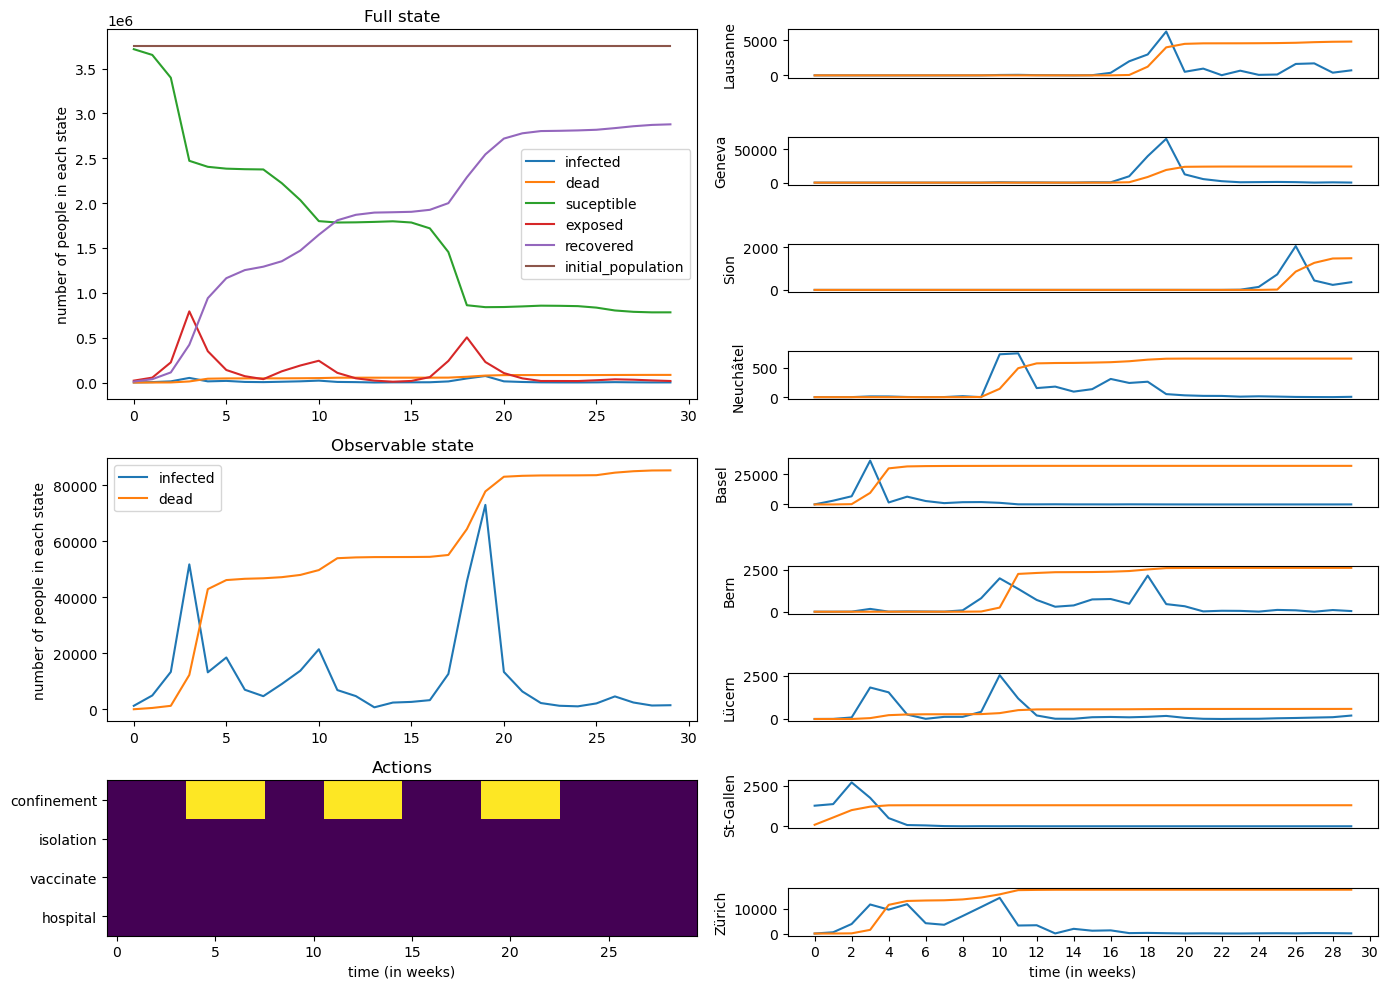

In [47]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=action_preprocessor) 
agent = Russo(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)
agent.reset()
eval_trace_russo = []

while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) 
    eval_trace_russo.append(R.item())
   
total, cities, actions = parse_logs(dyn, log)

plot_info(total, cities, actions)

Text(0.5, 1.0, 'Russo Policy')

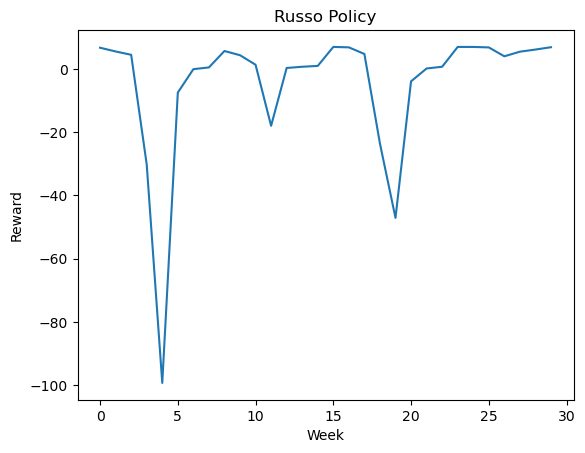

In [48]:
plt.plot(eval_trace_russo)
plt.xlabel('Week')
plt.ylabel('Reward')
plt.title('Russo Policy')

**Discussion :**<br>
In this case, the number of infected people starts to increase dramatically around week 2 and 3, just as in the first case. However, our agent detects this and imopses a 4 week confinement which almost immediately, drops this infection rate instead of leaving it at a constant rate like the unmitigated scenario. The rate of mortality also goes up but stagnates after the confinement. Later, the number of infected people reaches 20'000 which is dropped immediately by our policy. However, by the end of the second 4-week confinement, we witness a third much bigger wave which was again stopped by the policy but nevertheless, the number of deaths increases to reach a maximum value.
In summary, Pr.Russo policy responds the epidemic better than the unmitagated scenario as expected. This policy results in total, in 3 controlled waves instead of a single persistent one. 
<br>
(Nahkiw ala kol city feha zouz waves instead of wahda walé ? )
<br>
One might also notice the different magnitude of the infection and mortality rates between the two scenarios. 

**Question 2.b)** Evaluate Pr. Russo’s Policy

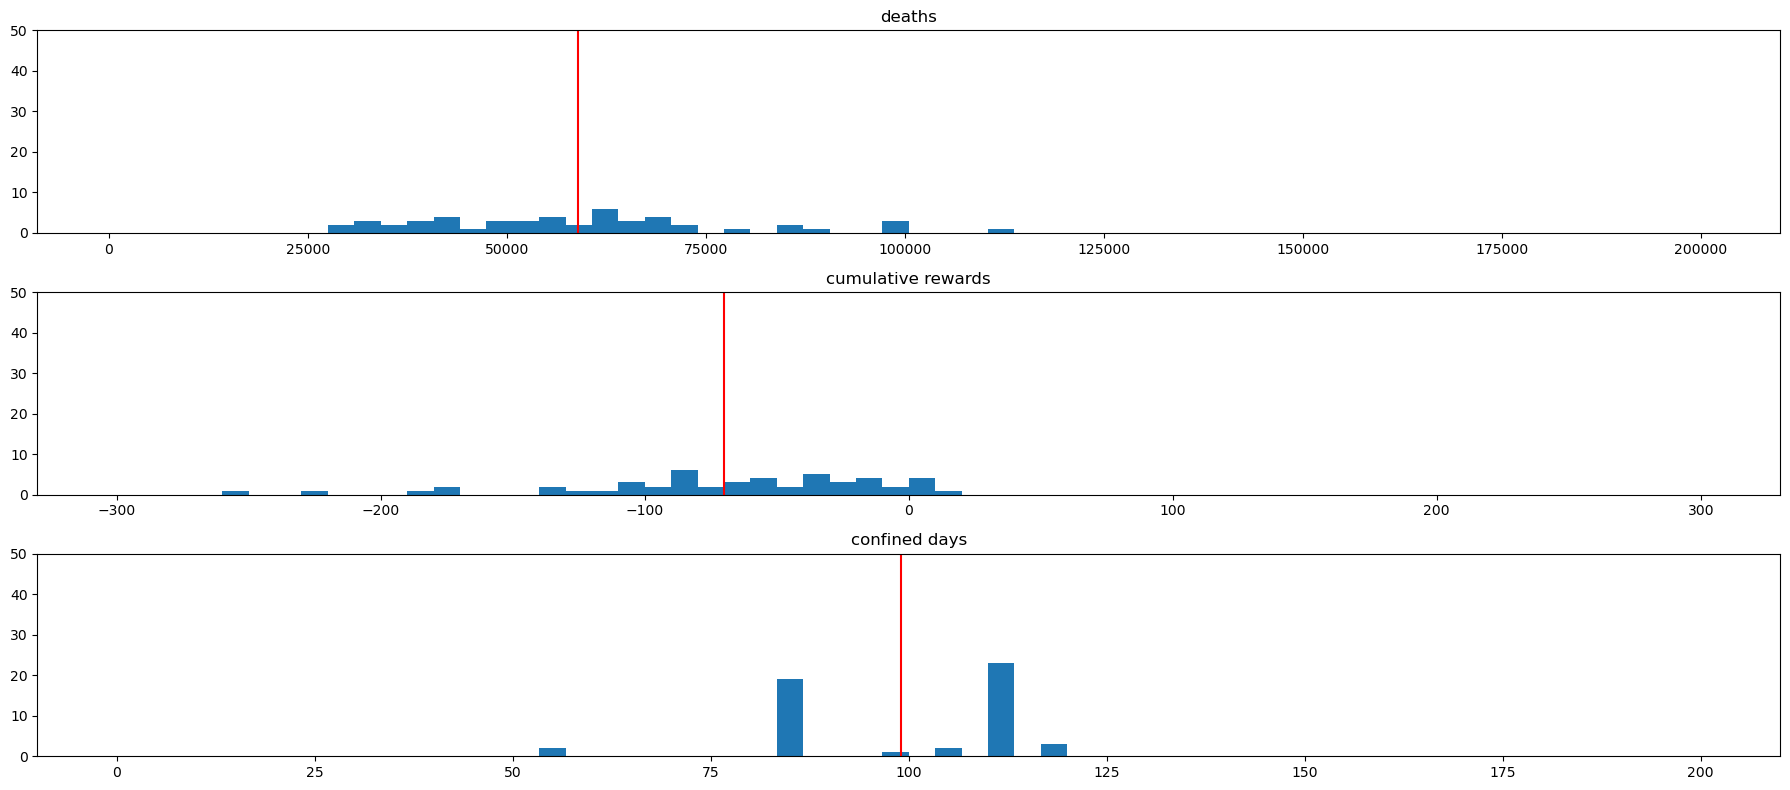

Average death number: 58922.9
Average number of confined days: 98.98
Average cumulative reward: -69.82


In [49]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=action_preprocessor) # create environment
agent = Russo(env)

"""Log the results"""
nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded"""
for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   
    agent.reset()
    for t in range(30):
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')



### 3 A Deep Q-learning approach

In [50]:
"""Constants for Part 3 and 4"""

BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3  # change to 1e-4 for part 4

##### 3.1 Deep Q-Learning with a binary action space

In [51]:
import torch.nn as nn
import random
from collections import namedtuple, deque
import torch.nn.functional as F


class QLearningModel(nn.Module):
    """Neural Network for Q-Learning"""

    def __init__(self,input_size=6 ,  output_size=2):
        super(QLearningModel, self).__init__()
        self.fc0 = nn.Linear(input_size, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    



class ReplayMemory(object):
    """Replay Memory that stores the transitions"""

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Utils.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

**Question 3.a)** implementing Deep Q-Learning

In [52]:
class QAgent(Agent):
    """Q-Learning Agent"""

    def __init__(self, env,device,input_size):
        self.env = env

        self.policy_network = QLearningModel(input_size=input_size)
        self.target_network = QLearningModel(input_size=input_size)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=LR)

        self.input_size = input_size
        self.memory = ReplayMemory(20000)
        self.device = device

    
    def load_model(self, savepath):

        self.policy_network.load_state_dict(torch.load(savepath+str("policy.pt")))
        self.target_network.load_state_dict(torch.load(savepath+str("target.pt")))
        return
      
        

    def save_model(self, savepath):
        torch.save(self.policy_network.state_dict(), savepath+str("policy")+str(".pt"))
        torch.save(self.target_network.state_dict(), savepath+str("target")+str(".pt"))
        return

    def remember(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)


    def optimize_model(self,episode,gamma=GAMMA):

        batch_size = BATCH_SIZE
        # if memory is smaller than batch size, do nothing
        if len(self.memory) < BATCH_SIZE:
            return
            
        
        # sample a batch from Memory
        transitions = self.memory.sample(batch_size)

        batch = Utils.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(torch.flatten(state_batch, start_dim=1)).gather(1, action_batch)

       
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(torch.flatten(non_final_next_states, start_dim=1)).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * gamma) + reward_batch.squeeze(1)
       
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # every 5 episodes update the target network
        if episode % 5 == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
        
       

       
    
    def reset(self):
        # This should be called when the environment is reset
        self.policy_network = QLearningModel(input_size=self.input_size)
        self.target_network = QLearningModel(input_size=self.input_size)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        # Define the optimizer
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=LR)
        self.memory = ReplayMemory(20000)

    def act(self, obs,eps,eps_decay=False,eps_min=None,num_episodes=None,episode=None):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        sample = random.random()
        if eps_decay : 
            eps_threshold = max(eps_min,eps *(num_episodes - episode ) / num_episodes)
        else : 
            eps_threshold = eps

        if sample < 1 - eps_threshold:
            with torch.no_grad():
                # return the action with the highest q value (index of the max q value)
                return self.policy_network(torch.flatten(obs, start_dim=1)).max(1)[1].view(1, 1)
      
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)



In [53]:
# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space (confine or not)
action_space  =   spaces.Discrete(2)

# define the observation space (never used , Nahiwha ?)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=action_preprocessor,observation_preprocessor=observation_preprocessor)

# Define the agent

# input_size of the policy network : nb_cities * days_of_week(7) * 2(nb_observables)
input_size = 2* dyn.n_cities* dyn.env_step_length
agent = QAgent(env, device , input_size=input_size) 




# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20


# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_dqn = np.zeros((num_traces, num_episodes))
eval_trace_dqn = np.zeros((num_traces, num_episodes))


for trace in range(num_traces):
    agent.reset()
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed+episode)
        done = False
        cumulative_reward = 0
    
        while not done:
            action = agent.act(obs, eps=EPS)
            next_obs, R, done, info = env.step(action)
            
            if done:
                next_obs = None
          
            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += int(R)

            # Run a traing step
            agent.optimize_model(episode=episode)
    
        
        # Log the cumulative reward to the training trace
        train_trace_dqn[trace, episode] = int(cumulative_reward)
        
        
        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                while not done:
                    action = agent.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R

            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)

            if eval_average_reward > best_reward:
                print(' New best model found !')
                agent.save_model(savepath='models/best_model')
                best_reward = eval_average_reward

            
            # Log the evaluation results to the evaluation trace
            eval_trace_dqn[trace , episode] = eval_average_reward
            
            print(f"Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")


Trace 0 Episode: 0, Train Reward: -253.00, Eval Reward: 12.00
Trace 0 Episode: 50, Train Reward: -120.00, Eval Reward: 12.00
Trace 0 Episode: 100, Train Reward: -201.00, Eval Reward: 32.00
Trace 0 Episode: 150, Train Reward: -95.00, Eval Reward: 31.00
Trace 0 Episode: 200, Train Reward: -47.00, Eval Reward: 29.00
Trace 0 Episode: 250, Train Reward: -119.00, Eval Reward: 32.00
Trace 0 Episode: 300, Train Reward: -99.00, Eval Reward: 29.00
Trace 0 Episode: 350, Train Reward: -115.00, Eval Reward: 27.00
Trace 0 Episode: 400, Train Reward: 0.00, Eval Reward: 30.00
Trace 0 Episode: 450, Train Reward: -21.00, Eval Reward: 31.00
 New best model found !
Trace 0 Episode: 499, Train Reward: -95.00, Eval Reward: 37.00
Trace 1 Episode: 0, Train Reward: -254.00, Eval Reward: -148.00
Trace 1 Episode: 50, Train Reward: -179.00, Eval Reward: -148.00
Trace 1 Episode: 100, Train Reward: -105.00, Eval Reward: 28.00
Trace 1 Episode: 150, Train Reward: -61.00, Eval Reward: 27.00
Trace 1 Episode: 200, Train

In [54]:

with open('traces/eval_trace_dqn.npy', 'wb') as f:
    np.save(f, eval_trace_dqn)
with open('traces/train_trace_dqn.npy', 'wb') as f:
    np.save(f, train_trace_dqn)

Text(0, 0.5, 'Reward')

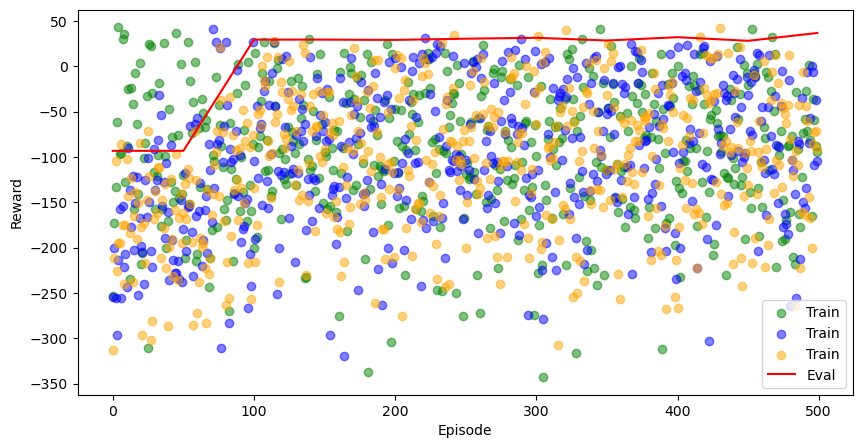

In [55]:
"""Plotting the training and evaluation traces"""
# replace zeros in the evaluation trace with None
eval_trace_dqn[eval_trace_dqn == 0] = None
avg_eval_trace = np.mean(eval_trace_dqn,axis=0)
episodes = np.arange(num_episodes)

# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']

[plt.scatter(np.arange(num_episodes),train_trace_dqn[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
plt.plot(episodes[~np.isnan(avg_eval_trace)],avg_eval_trace[~np.isnan(avg_eval_trace)],label='Eval',color='red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')

/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/3746690819.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/3746690819.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


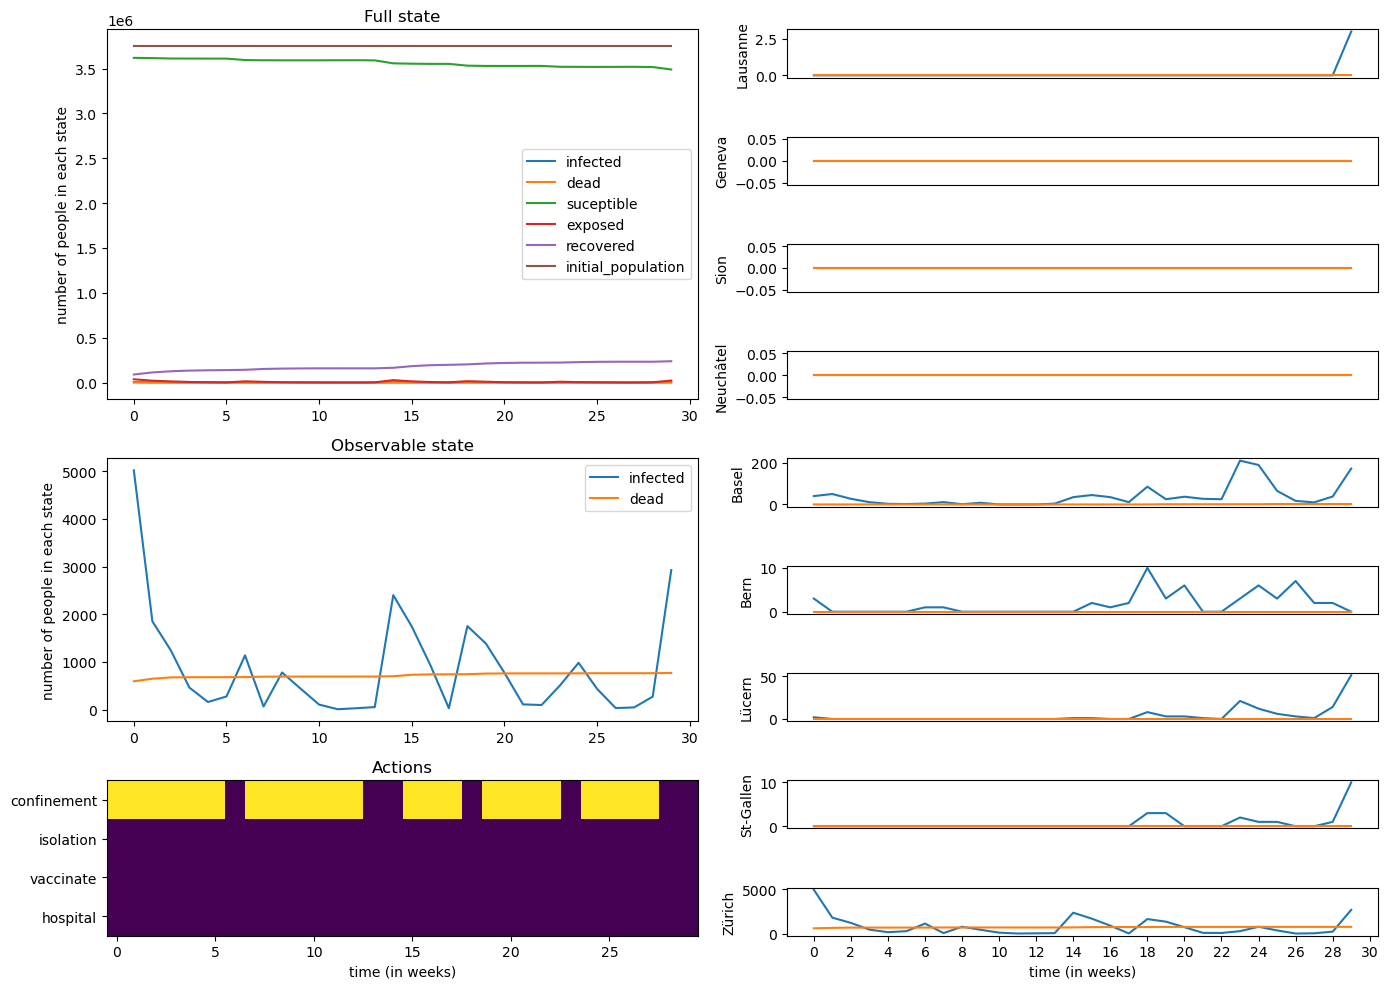

In [56]:
""" Run the simulation 3 times and plot last episode """
# load the best model
agent.load_model('models/best_model')

for i in range(3):
    obs , info = env.reset(seed+i)
    log = []
    finished = False
    while not finished:
        
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
                
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
    
        log.append(info) # save the information dict for logging
    
        
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

Interpretration : TODO

##### Question 3.b) decreasing exploration

In [57]:
# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space (confine or not)
action_space  =   spaces.Discrete(2)

# define the observation space (never used , Nahiwha ?)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=action_preprocessor,observation_preprocessor=observation_preprocessor)

# Define the agent

# input_size of the policy network : nb_cities * days_of_week(7) * 2(nb_observables)
input_size = 2* dyn.n_cities* dyn.env_step_length
agent = QAgent(env, device , input_size=input_size) 




# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20


# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_dqn_2 = np.zeros((num_traces, num_episodes))
eval_trace_dqn_2 = np.zeros((num_traces, num_episodes))

best_reward = -math.inf
for trace in range(num_traces):
    agent.reset()
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed+episode)
        done = False
        cumulative_reward = 0
    
        while not done:
            action = agent.act(obs, eps=EPS,episode=episode,eps_decay=True,eps_min=0.2,num_episodes=num_episodes)
            next_obs, R, done, info = env.step(action)
            
            if done:
                next_obs = None
          
            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += int(R)

            # Run a traing step
            agent.optimize_model(episode=episode)
    
        
        # Log the cumulative reward to the training trace
        train_trace_dqn_2[trace, episode] = int(cumulative_reward)
        
        
    
        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                while not done:
                    action = agent.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R

            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)

            if eval_average_reward > best_reward:
                print(' New best model found !')
                agent.save_model(savepath='models/best_model_decreasing')
                best_reward = eval_average_reward

            
            # Log the evaluation results to the evaluation trace
            eval_trace_dqn_2[trace , episode] = eval_average_reward
            
            print(f"Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")


 New best model found !
Trace 0 Episode: 0, Train Reward: -209.00, Eval Reward: -148.00
Trace 0 Episode: 50, Train Reward: -218.00, Eval Reward: -148.00
 New best model found !
Trace 0 Episode: 100, Train Reward: -62.00, Eval Reward: 25.00
 New best model found !
Trace 0 Episode: 150, Train Reward: -162.00, Eval Reward: 26.00
 New best model found !
Trace 0 Episode: 200, Train Reward: 6.00, Eval Reward: 31.00
 New best model found !
Trace 0 Episode: 250, Train Reward: 26.00, Eval Reward: 37.00
Trace 0 Episode: 300, Train Reward: 6.00, Eval Reward: 31.00
 New best model found !
Trace 0 Episode: 350, Train Reward: -140.00, Eval Reward: 39.00
 New best model found !
Trace 0 Episode: 400, Train Reward: 8.00, Eval Reward: 41.00
Trace 0 Episode: 450, Train Reward: 18.00, Eval Reward: 36.00
Trace 0 Episode: 499, Train Reward: 18.00, Eval Reward: 41.00
Trace 1 Episode: 0, Train Reward: -180.00, Eval Reward: 23.00
Trace 1 Episode: 50, Train Reward: -13.00, Eval Reward: 23.00
Trace 1 Episode: 10

In [58]:

with open('traces/eval_trace_dqn_2.npy', 'wb') as f:
    np.save(f, eval_trace_dqn_2)
with open('traces/train_trace_dqn_2.npy', 'wb') as f:
    np.save(f, train_trace_dqn_2)

Text(0.5, 1.0, 'Training Reward for 3 traces for constant eps')

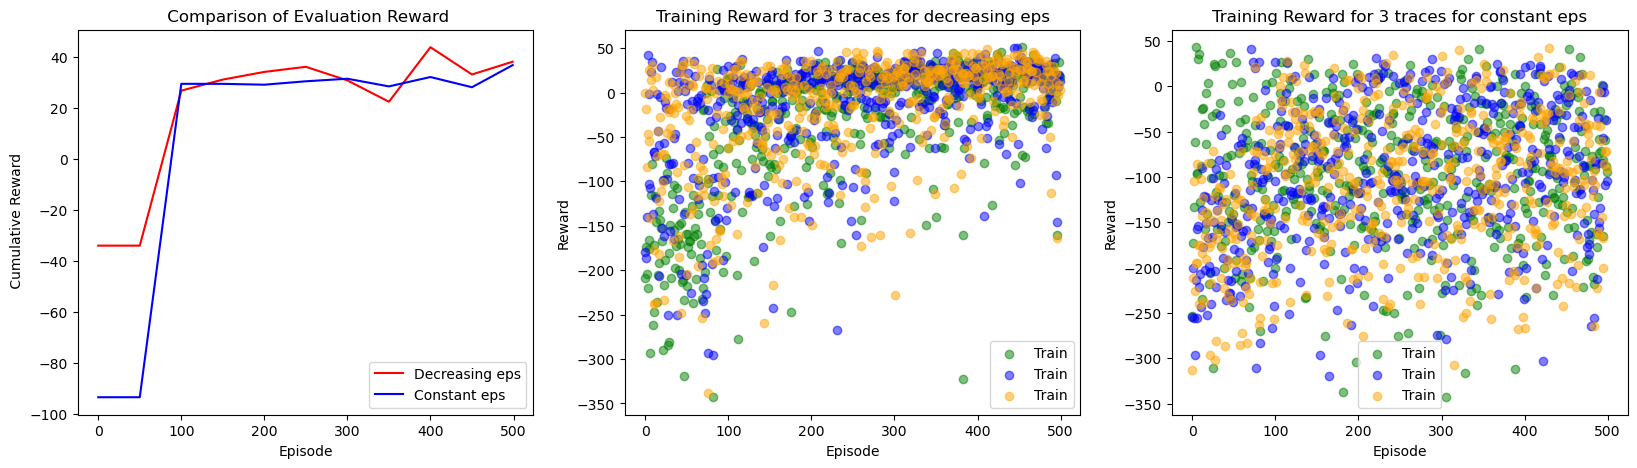

In [144]:
#if you want to plot the traces from the saved files
eval_trace_dqn_2 = np.load('traces/eval_trace_dqn_2.npy')
train_trace_dqn_2 = np.load('traces/train_trace_dqn_2.npy')
train_trace_dqn = np.load('traces/train_trace_dqn.npy')

# replace zeros in the evaluation trace with None
eval_trace_dqn_2[eval_trace_dqn_2 == 0] = None
episodes = np.arange(num_episodes)
avg_eval_trace_2 = np.mean(eval_trace_dqn_2,axis=0)

# crete a plot with 2 subplots
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,5))
# plot both evaluation traces 
ax1.plot(episodes[~np.isnan(avg_eval_trace_2)],avg_eval_trace_2[~np.isnan(avg_eval_trace_2)],label='Decreasing eps',color='red')
ax1.plot(episodes[~np.isnan(avg_eval_trace)],avg_eval_trace[~np.isnan(avg_eval_trace)],label='Constant eps',color='blue')
ax1.legend()
ax1.set_xlabel('Episode')
ax1.set_ylabel(' Cumulative Reward')
ax1.set_title(' Comparison of Evaluation Reward')

# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']
[ax2.scatter(np.arange(num_episodes),train_trace_dqn_2[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
ax2.legend()
ax2.set_xlabel('Episode')
ax2.set_ylabel('Reward')
ax2.set_title('Training Reward for 3 traces for decreasing eps')


# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']
[ax3.scatter(np.arange(num_episodes),train_trace_dqn[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
ax3.legend()
ax3.set_xlabel('Episode')
ax3.set_ylabel('Reward')
ax3.set_title('Training Reward for 3 traces for constant eps')


##### Question 3.c) evaluate the best performing policy against Pr. Russo’s policy

/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/599429373.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/599429373.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


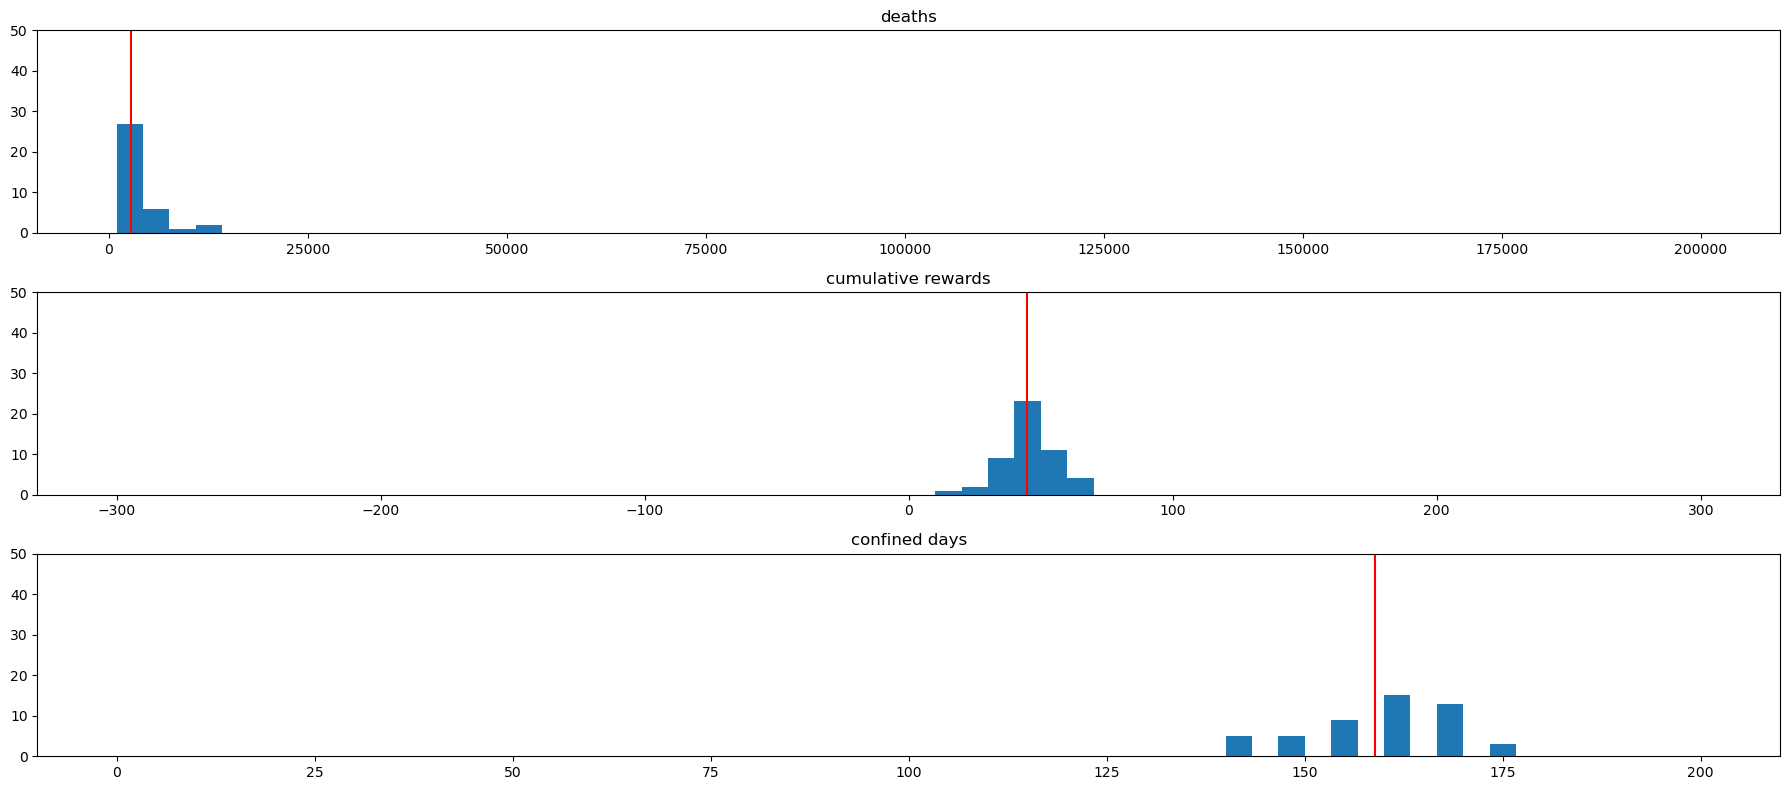

Average death number: 2767.1
Average number of confined days: 158.9
Average cumulative reward: 44.62


In [60]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map

action_space  =   spaces.Discrete(2)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=action_preprocessor,observation_preprocessor=observation_preprocessor)

# Define the agent
agent = QAgent(env, device , 2* dyn.n_cities* dyn.env_step_length)

agent.load_model('models/best_model_decreasing')

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded"""
for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   

    for t in range(30):
        action = agent.act(obs, eps=0.0)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        obs, R, finished, info = env.step(action)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')



/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/4212422098.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/4212422098.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


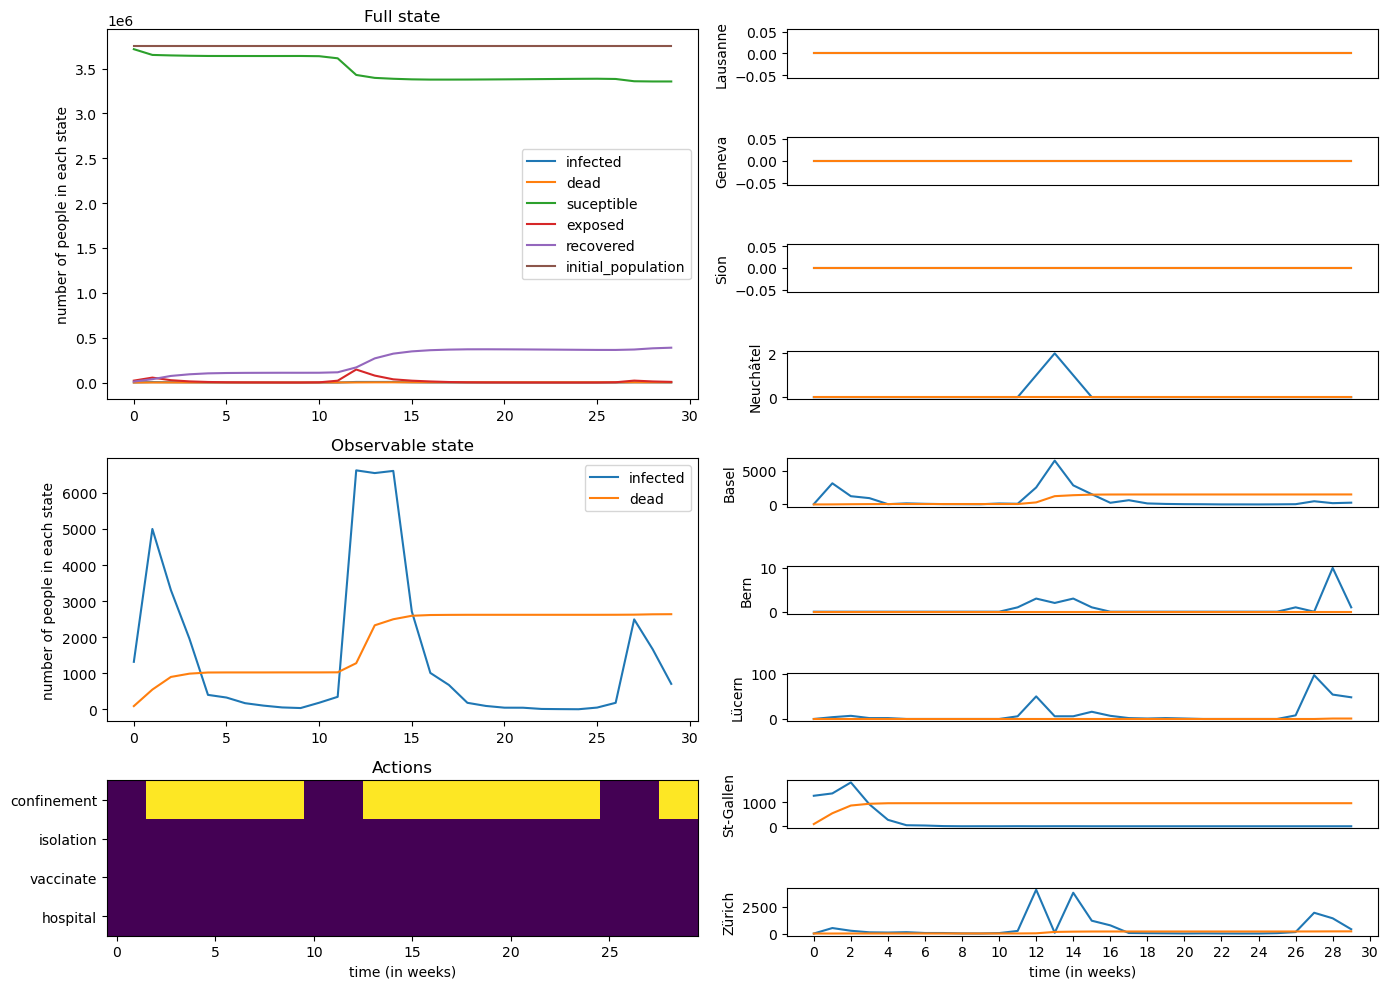

In [61]:
""" Run an episode of the best model to interpret the results """
log = []
finished = False
obs, info = env.reset(seed)

while not finished:
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    log.append(info) # save the information dict for logging
  
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

### Part 4 : Dealing with a more complex action Space

#### 4.1 Toggle-action-space multi-action agent


##### Question 4.1.a) (Theory) Action space design TODO

##### Question 4.1.b) Toggle-action-space multi-action policy training

In [62]:
class QAgentMulti(Agent):

    def __init__(self, env,device,input_size,lr=LR):
        self.env = env
        self.lr = lr
        self.policy_network = QLearningModel(input_size=input_size,output_size=5)
        self.target_network = QLearningModel(input_size=input_size,output_size=5)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.input_size = input_size
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=self.lr,amsgrad=True)

        self.memory = ReplayMemory(20000)
        self.device = device

    
    def load_model(self, savepath):

        self.policy_network.load_state_dict(torch.load(savepath+str("policy.pt")))
        self.target_network.load_state_dict(torch.load(savepath+str("target.pt")))
        return
      
        

    def save_model(self, savepath):
        torch.save(self.policy_network.state_dict(), savepath+str("policy")+str(".pt"))
        torch.save(self.target_network.state_dict(), savepath+str("target")+str(".pt"))
        return

    def remember(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)


    def optimize_model(self,episode,gamma=GAMMA):

        batch_size = BATCH_SIZE
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(batch_size)
       
        batch = Utils.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
      
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)

        reward_batch = torch.cat(batch.reward)

      

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)


        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * gamma) + reward_batch.squeeze(1)

 
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
       # torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)

        self.optimizer.step()

        
        if episode % 5 == 0:
            target_net_state_dict = self.target_network.state_dict()
            policy_net_state_dict = self.policy_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]
            self.target_network.load_state_dict(target_net_state_dict)
        

       
    
    def reset(self):
        # This should be called when the environment is reset
        self.policy_network = QLearningModel(input_size=self.input_size,output_size=5)
        self.target_network = QLearningModel(input_size=self.input_size,output_size=5)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=self.lr,amsgrad=True)

        self.memory = ReplayMemory(20000)

    def act(self, obs,eps,eps_decay=False,eps_min=None,num_episodes=None,episode=None):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        sample = random.random()
        if eps_decay : 
            eps_threshold = max(eps_min,eps *(num_episodes - episode ) / num_episodes)
        else : 
            eps_threshold = eps

        if sample < 1 - eps_threshold:
            with torch.no_grad():
               
                # take action with highest predicted Q value
                output =  self.policy_network(obs).max(1)[1].view(1, 1)
                return output
      
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)


    
        


In [63]:
def action_preprocessor_toggle(a:torch.Tensor,  dyn:ModelDynamics):
        """Action preprocessor for toggling actions"""
      
        last_action = dyn.get_action().copy()

        if a == ACTION_NULL:

            return last_action
        
        if a == ACTION_CONFINE:
            last_action['confinement'] = not last_action['confinement']
        elif a == ACTION_ISOLATE:
            last_action['isolation'] = not last_action['isolation']
        elif a == ACTION_VACCINATE:
            last_action['vaccinate'] = not last_action['vaccinate']
        elif a == ACTION_HOSPITAL:
            last_action['hospital'] = not last_action['hospital']
            
       
        return  last_action

In [64]:
# Learning rate reduced
LR = 1e-4

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space
action_space  =   spaces.Discrete(5)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)


# Define the environment
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=action_preprocessor_toggle,observation_preprocessor=observation_preprocessor_action)


# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 ,lr=LR)


# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20

# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_3 = np.zeros((num_traces,num_episodes))
eval_trace_3 = np.zeros((num_traces,num_episodes))

# best reward
best_reward = -math.inf 

for trace in range(num_traces):
    agent.reset()
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed=seed+episode)
        done = False
        cumulative_reward = 0
        while not done:
            action = agent.act(obs, eps=EPS,eps_decay=True,episode=episode,num_episodes=num_episodes,eps_min=0.2)
            next_obs, R, done, info = env.step(action)          
            if done:
                next_obs = None
           
            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += float(R)

              # Run a traing step
            agent.optimize_model(episode=episode)
         
        # Log the cumulative reward to the training trace
        train_trace_3[trace,episode] = int(cumulative_reward)
        

        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                while not done:
                    action = agent.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += float(R)
            
            eval_average_reward = eval_cumulative_reward / num_eval_episodes

            if eval_average_reward > best_reward:
                agent.save_model(savepath='models/best_model_multi')
                best_reward = eval_average_reward

            # Log the evaluation results to the evaluation trace
            eval_trace_3[trace,episode] = eval_average_reward
            
            print(f" Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")
    

 Trace 0 Episode: 0, Train Reward: 1.00, Eval Reward: -231.72
 Trace 0 Episode: 50, Train Reward: -155.00, Eval Reward: -231.72
 Trace 0 Episode: 100, Train Reward: -138.00, Eval Reward: -164.00
 Trace 0 Episode: 150, Train Reward: -89.00, Eval Reward: -47.99
 Trace 0 Episode: 200, Train Reward: -20.00, Eval Reward: -68.29
 Trace 0 Episode: 250, Train Reward: 11.00, Eval Reward: -67.09
 Trace 0 Episode: 300, Train Reward: 20.00, Eval Reward: -50.30
 Trace 0 Episode: 350, Train Reward: -123.00, Eval Reward: -26.83
 Trace 0 Episode: 400, Train Reward: 34.00, Eval Reward: -11.33
 Trace 0 Episode: 450, Train Reward: 6.00, Eval Reward: 2.32
 Trace 0 Episode: 499, Train Reward: 11.00, Eval Reward: 13.70
 Trace 1 Episode: 0, Train Reward: -162.00, Eval Reward: -89.06
 Trace 1 Episode: 50, Train Reward: -148.00, Eval Reward: -89.06
 Trace 1 Episode: 100, Train Reward: -86.00, Eval Reward: -91.60
 Trace 1 Episode: 150, Train Reward: -100.00, Eval Reward: -72.77
 Trace 1 Episode: 200, Train Rewa

In [65]:
with open('traces/eval_trace_toggle.npy', 'wb') as f:
    np.save(f, eval_trace_3) 
with open('traces/train_trace_toggle.npy', 'wb') as f:
    np.save(f, train_trace_3)

Text(0, 0.5, 'Reward')

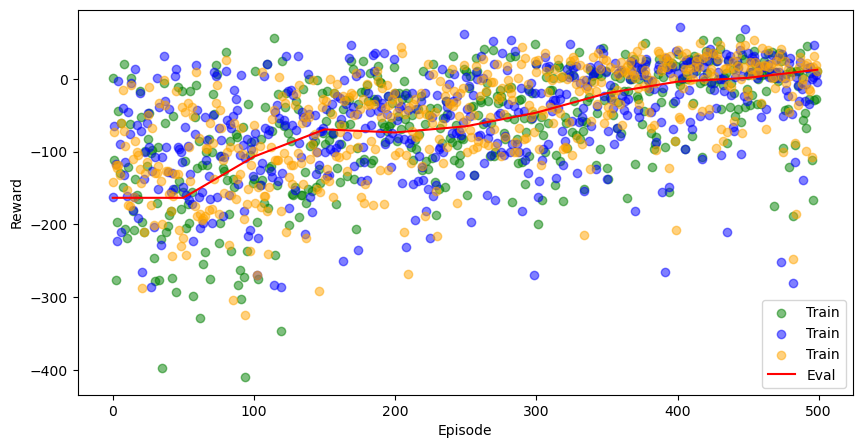

In [66]:
"""Plotting the training and evaluation traces"""
#if you want to plot the traces from the saved files
#eval_trace_3 = np.load('traces/eval_trace_toggle.npy')
#train_trace_3 = np.load('traces/train_trace_toggle.npy')

# replace zeros in the evaluation trace with None
eval_trace_3[eval_trace_3 == 0] = None
avg_eval_trace_3 = np.mean(eval_trace_3,axis=0)
episodes = np.arange(num_episodes)

# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']

[plt.scatter(np.arange(num_episodes),train_trace_3[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
plt.plot(episodes[~np.isnan(avg_eval_trace_3)],avg_eval_trace_3[~np.isnan(avg_eval_trace_3)],label='Eval',color='red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')

/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/2723631330.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/2723631330.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


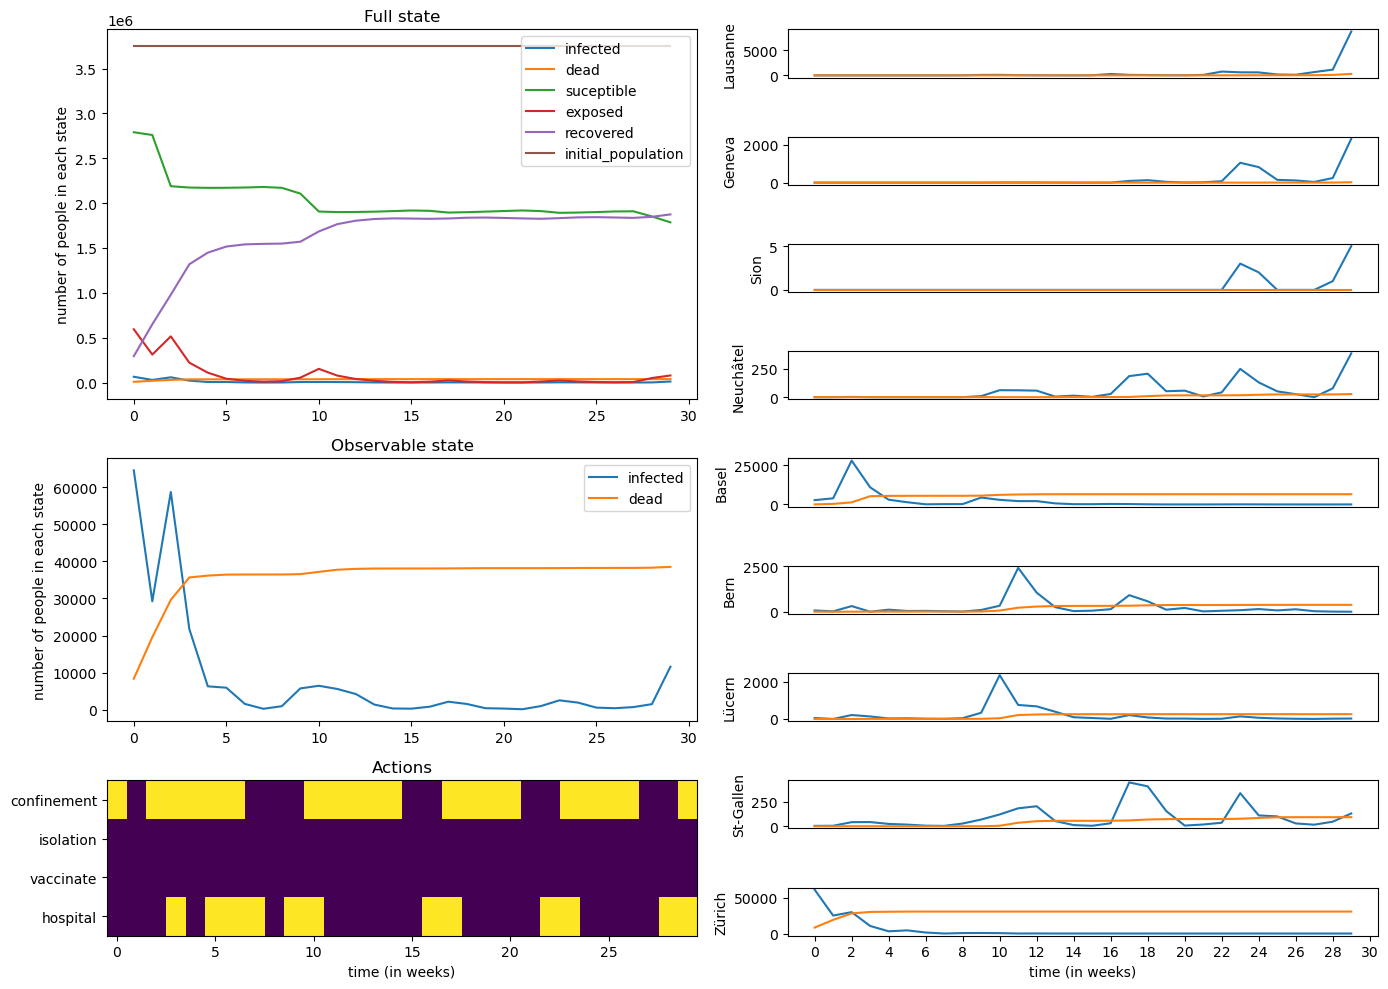

In [67]:
""" Run the simulation 3 times and plot last episode """
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
action_space  =   spaces.Discrete(5)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=action_preprocessor_toggle,observation_preprocessor=observation_preprocessor_action)

# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 )
agent.load_model('models/best_model_multi')

for i in range(3):
    obs , info = env.reset(seed+i)
    log = []
    finished = False
    while not finished:
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        log.append(info) # save the information dict for logging
    
        
total, cities, actions = parse_logs(dyn, log)

plot_info(total, cities, actions)

##### Question 4.1.c) Toggle-action-space multi-action policy evaluation

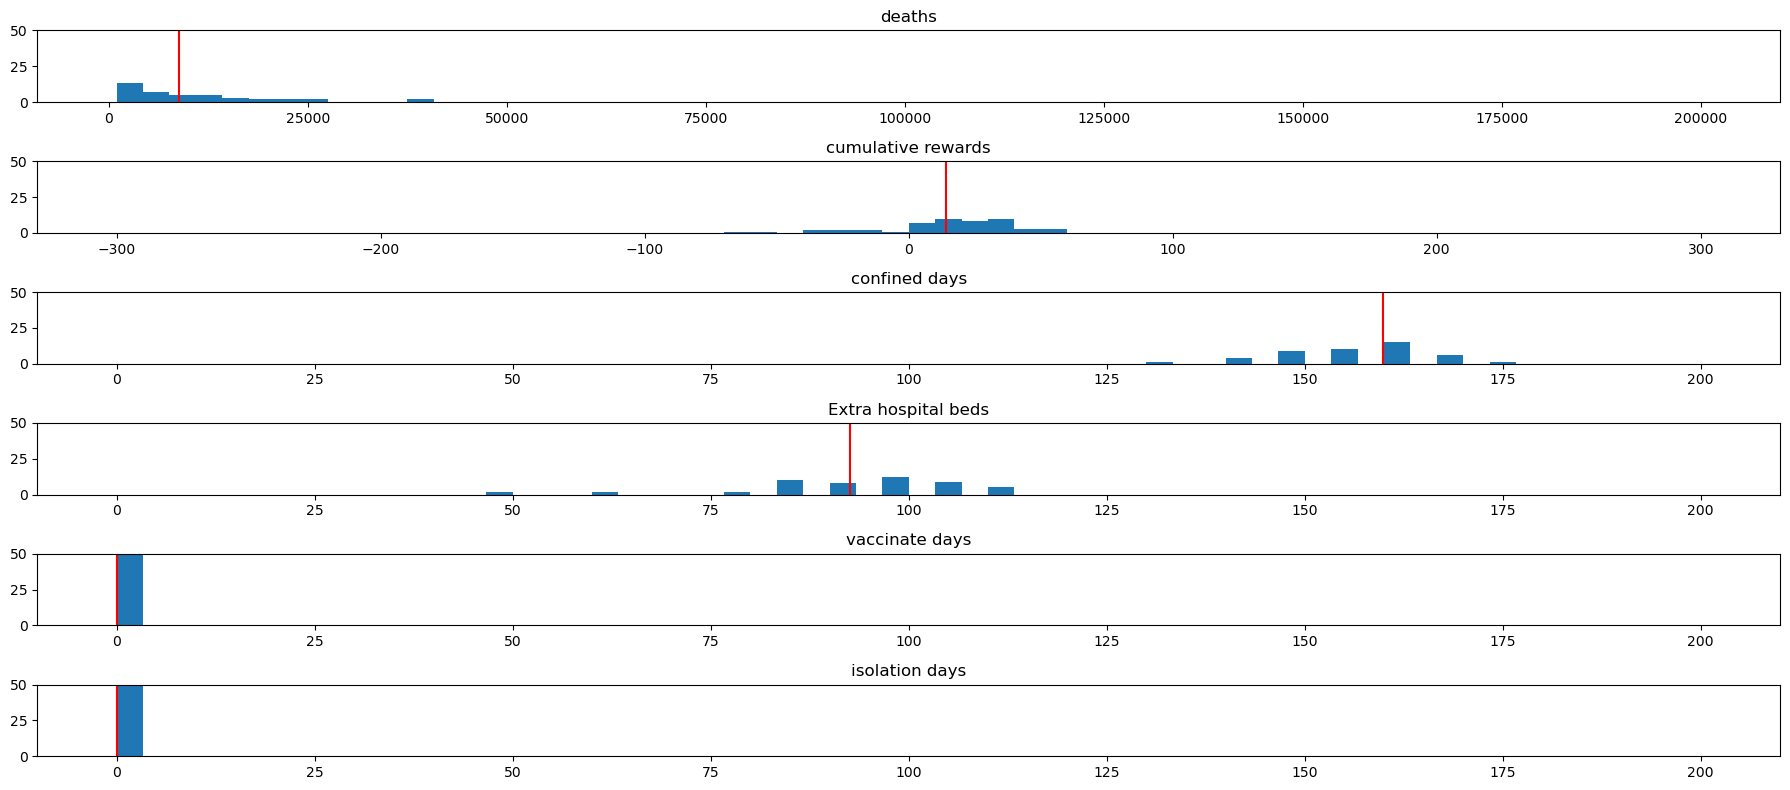

Average death number: 8776.22
Average number of confined days: 159.88
Average cumulative reward: 14.24
Average number of hospital beds added: 92.54
Average number of isolation days: 0.0
Average number of vaccination days: 0.0
Median death number: 4671.0
Median number of confined days: 161.0
Median cumulative reward: 18.0


In [69]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
action_space  =   spaces.Discrete(5)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=action_preprocessor_toggle,observation_preprocessor=observation_preprocessor_action)
# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 )
agent.load_model('models/best_model_multi')

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []
nb_all_isolation = []
nb_all_hospitals = []
nb_all_vaccinate = []

"""Run the simulations, seeded 3 times"""

for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)

    for t in range(30):

        action = agent.act(obs, eps=0.0)
        
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    # compute the number of days in hospital
    nb_hospitals = np.sum(actions['hospital']) * 7
    nb_all_hospitals.append(nb_hospitals)

    # compute the number of days in vaccination
    nb_vaccinate = np.sum(actions['vaccinate']) * 7
    nb_all_vaccinate.append(nb_vaccinate)

    # compute the number of days in isolation
    nb_isolation = np.sum(actions['isolation']) * 7
    nb_all_isolation.append(nb_isolation)
""" Plot """
fig, ax = plt.subplots(6,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')
hist_avg(ax[3], nb_all_hospitals,'Extra hospital beds')
hist_avg(ax[4], nb_all_vaccinate,'vaccinate days')
hist_avg(ax[5], nb_all_isolation,'isolation days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')
print(f'Average number of hospital beds added: {np.mean(nb_all_hospitals)}')
print(f'Average number of isolation days: {np.mean(nb_all_isolation)}')
print(f'Average number of vaccination days: {np.mean(nb_all_vaccinate)}')

print(f'Median death number: {np.median(nb_all_deaths)}') 
print(f'Median number of confined days: {np.median(nb_all_confinement)}')
print(f'Median cumulative reward: {np.median(nb_all_rewards)}')

##### Question 4.1.d) (Theory) question about toggled-action-space policy, what assumption does it make?

#### 4.2 Factorized Q-values, multi-action agent


##### 4.2.a : multi-action factorized Q-values policy training

In [70]:
def action_preprocessor_factorized(a:torch.Tensor,dyn:ModelDynamics):
        """Action preprocessor"""
        return {'confinement':  bool(a[0]),
                'isolation':    bool(a[1]),
                'hospital':     bool(a[2]),
                'vaccinate':    bool(a[3]) }

In [71]:
def get_q_value(a: torch.tensor,batch_size,target_network,):
    """ For a specific state, get all the Q values by feeding it to the target network
        The Q values should be a tensor with nb rows = batch_size(number of states) each having 8 values corresponding to each decision. 
        First we need to select for each state the max Q value (in other words the optimal set of decisions)
        for [1 4 2 6 5 7 3 1] => [1 4 2 6] [5 7 3 1] => [5 7 3 6] (compare the two four elements one by one from each side)
        Finally we sum them up [5 7 2 6] => [20]
    """
    batch_size = a.shape[0]
    input_tensor = target_network(a).reshape(batch_size, 2, -1)
    max_values = torch.max(input_tensor, dim=1).values
    return torch.sum(max_values, dim=1)

In [72]:
class QAgentFactorized(Agent):
    def __init__(self, env,device,input_size):
        self.env = env
        self.input_size = input_size
        self.device = device
        self.memory = ReplayMemory(20000)
        self.policy_network = QLearningModel(input_size=input_size,output_size=8)
        self.target_network = QLearningModel(input_size=input_size,output_size=8)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=LR)
        
    
    def load_model(self, savepath):
        self.policy_network.load_state_dict(torch.load(savepath+str("policy.pt")))
        self.target_network.load_state_dict(torch.load(savepath+str("target.pt")))
        return
        
    def save_model(self, savepath):
        torch.save(self.policy_network.state_dict(), savepath+str("policy")+str(".pt"))
        torch.save(self.target_network.state_dict(), savepath+str("target")+str(".pt"))
        return

    def remember(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)

    def optimize_model(self,episode,gamma=GAMMA):
        batch_size = BATCH_SIZE
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(batch_size)
        batch = Utils.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state_batch = torch.cat(batch.state).view(batch_size,-1)
        action_batch = torch.cat(batch.action).view(batch_size,-1)
        reward_batch = torch.cat(batch.reward).view(batch_size,-1)

        # Compute Q(s_t, a) 
        # the model computes Q(s_t), then we select the columns of actions taken. 
        # These are the actions which would've been taken
        # for each batch state according to policy_net
        
        #adapt action batch to be used in gather function
        # need to go from [0 0 1 0] to [4 5 2 7] 
        indices = torch.add(torch.stack([torch.arange(4).reshape(1, -1)]*batch_size,dim=1).squeeze(),(1-action_batch)*4)
        state_action_values = self.policy_network(state_batch).gather(1, indices)

        state_action_values = torch.sum(state_action_values, dim=1)

       
        state_action_values.requires_grad_()

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size,requires_grad=True)
        with torch.no_grad():    
            next_state_values[non_final_mask] = get_q_value(torch.flatten(non_final_next_states,start_dim=1),batch_size=batch_size , target_network=self.target_network)
    
        expected_state_action_values = (next_state_values * gamma) + reward_batch.squeeze(1)
        
       
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values.unsqueeze(1), expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        if episode % 5 == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
    

    def reset(self):
        # This should be called when the environment is reset
        self.policy_network = QLearningModel(input_size=self.input_size,output_size=8)
        self.target_network = QLearningModel(input_size=self.input_size,output_size=8)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), lr=LR)

        self.memory = ReplayMemory(20000)

    def act(self, obs,eps,eps_decay=False,eps_min=None,num_episodes=None,episode=None):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        sample = random.random()
        if eps_decay : 
            eps_threshold = max(eps_min,eps *(num_episodes - episode ) / num_episodes)
        else : 
            eps_threshold = eps
        if sample < 1 - eps_threshold:  
            with torch.no_grad():
                # take action with highest predicted Q value
                q_values =  self.policy_network(obs.reshape(1, -1)).tolist()[0]
                return torch.tensor([ int(q_values[i] > q_values[i+4]) for i in range(4)],device=self.device   )
        else:
            return torch.tensor(self.env.action_space.sample(), device=self.device, dtype=torch.long)

In [73]:
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
action_space = spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(dyn, action_space=action_space,
           observation_space=observation_space, 
          action_preprocessor=action_preprocessor_factorized,
          observation_preprocessor=observation_preprocessor)

input_size = dyn.n_cities*2*dyn.env_step_length
agent = QAgentFactorized(env,device,input_size)

# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20

# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_4 = np.zeros((num_traces,num_episodes))
eval_trace_4 = np.zeros((num_traces,num_episodes))

# best reward
best_reward = -math.inf 

for trace in range(num_traces):
    
    agent.reset()

    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed=seed+episode)

        done = False
        cumulative_reward = 0

      
        while not done:
            action = agent.act(obs, eps=EPS,eps_decay=True,episode=episode,num_episodes=num_episodes,eps_min=0.2)
          
            next_obs, R, done, info = env.step(action)

          
            if done:
                next_obs = None
           

            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += float(R)

              # Run a traing step
            agent.optimize_model(episode=episode)
         
        # Log the cumulative reward to the training trace
        train_trace_4[trace,episode] = int(cumulative_reward)
        

        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                
                while not done:
                    action = agent.act(obs, eps=0.0)
               
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += float(R)
                  
                
            eval_average_reward = eval_cumulative_reward / num_eval_episodes
            if eval_average_reward > best_reward:
                agent.save_model(savepath='models/best_model_multi_factorized')
                best_reward = eval_average_reward

            
            # Log the evaluation results to the evaluation trace
            eval_trace_4[trace,episode] = eval_average_reward
            
            print(f" Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")

 Trace 0 Episode: 0, Train Reward: -107.00, Eval Reward: -96.72
 Trace 0 Episode: 50, Train Reward: -333.00, Eval Reward: -96.72
 Trace 0 Episode: 100, Train Reward: -143.00, Eval Reward: -1.77
 Trace 0 Episode: 150, Train Reward: -86.00, Eval Reward: -3.16
 Trace 0 Episode: 200, Train Reward: -75.00, Eval Reward: 7.23
 Trace 0 Episode: 250, Train Reward: -50.00, Eval Reward: 11.95
 Trace 0 Episode: 300, Train Reward: -66.00, Eval Reward: 15.19
 Trace 0 Episode: 350, Train Reward: -111.00, Eval Reward: 12.78
 Trace 0 Episode: 400, Train Reward: 2.00, Eval Reward: 14.82
 Trace 0 Episode: 450, Train Reward: -17.00, Eval Reward: 18.32
 Trace 0 Episode: 499, Train Reward: -34.00, Eval Reward: 26.82
 Trace 1 Episode: 0, Train Reward: -74.00, Eval Reward: 8.97
 Trace 1 Episode: 50, Train Reward: -125.00, Eval Reward: 8.97
 Trace 1 Episode: 100, Train Reward: -39.00, Eval Reward: 15.49
 Trace 1 Episode: 150, Train Reward: -1.00, Eval Reward: 25.23
 Trace 1 Episode: 200, Train Reward: -23.00, 

In [74]:
with open('traces/eval_trace_fact.npy', 'wb') as f:
    np.save(f, eval_trace_4)
with open('traces/train_trace_fact.npy','wb') as f:
    np.save(f, train_trace_4)

Text(0, 0.5, 'Reward')

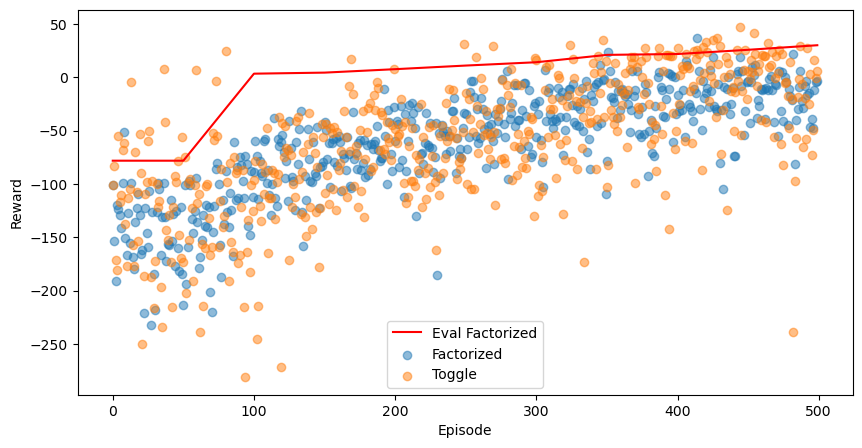

In [75]:
"""Plotting the training and evaluation traces"""
#if you want to plot the traces from the saved files
#eval_trace_4 = np.load('traces/eval_trace_fact.npy')
#train_trace_4 = np.load('traces/train_trace_fact.npy')

# replace zeros in the evaluation trace with None
eval_trace_4[eval_trace_4 == 0] = None
avg_eval_trace_4 = np.mean(eval_trace_4,axis=0)
episodes = np.arange(num_episodes)

# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']

#[plt.scatter(np.arange(num_episodes),train_trace_4[t],label=f'Train{t}',alpha=0.5,color=colors[t]) for t in range(num_traces)]
plt.plot(episodes[~np.isnan(avg_eval_trace_4)],avg_eval_trace_4[~np.isnan(avg_eval_trace_4)],label='Eval Factorized',color='red')
train_fact_avg = [ np.mean(l)for l in np.transpose(train_trace_4)]
plt.scatter(np.arange(num_episodes),train_fact_avg,label='Factorized',alpha=0.5)


# plot the average evaluation trace of toggle
train_trace_toggle = np.load('traces/train_trace_toggle.npy')
train_toggle_avg = [ np.mean(l)for l in np.transpose(train_trace_toggle)]
plt.scatter(np.arange(num_episodes),train_toggle_avg,label='Toggle',alpha=0.5)
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')

/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/792502024.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/792502024.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


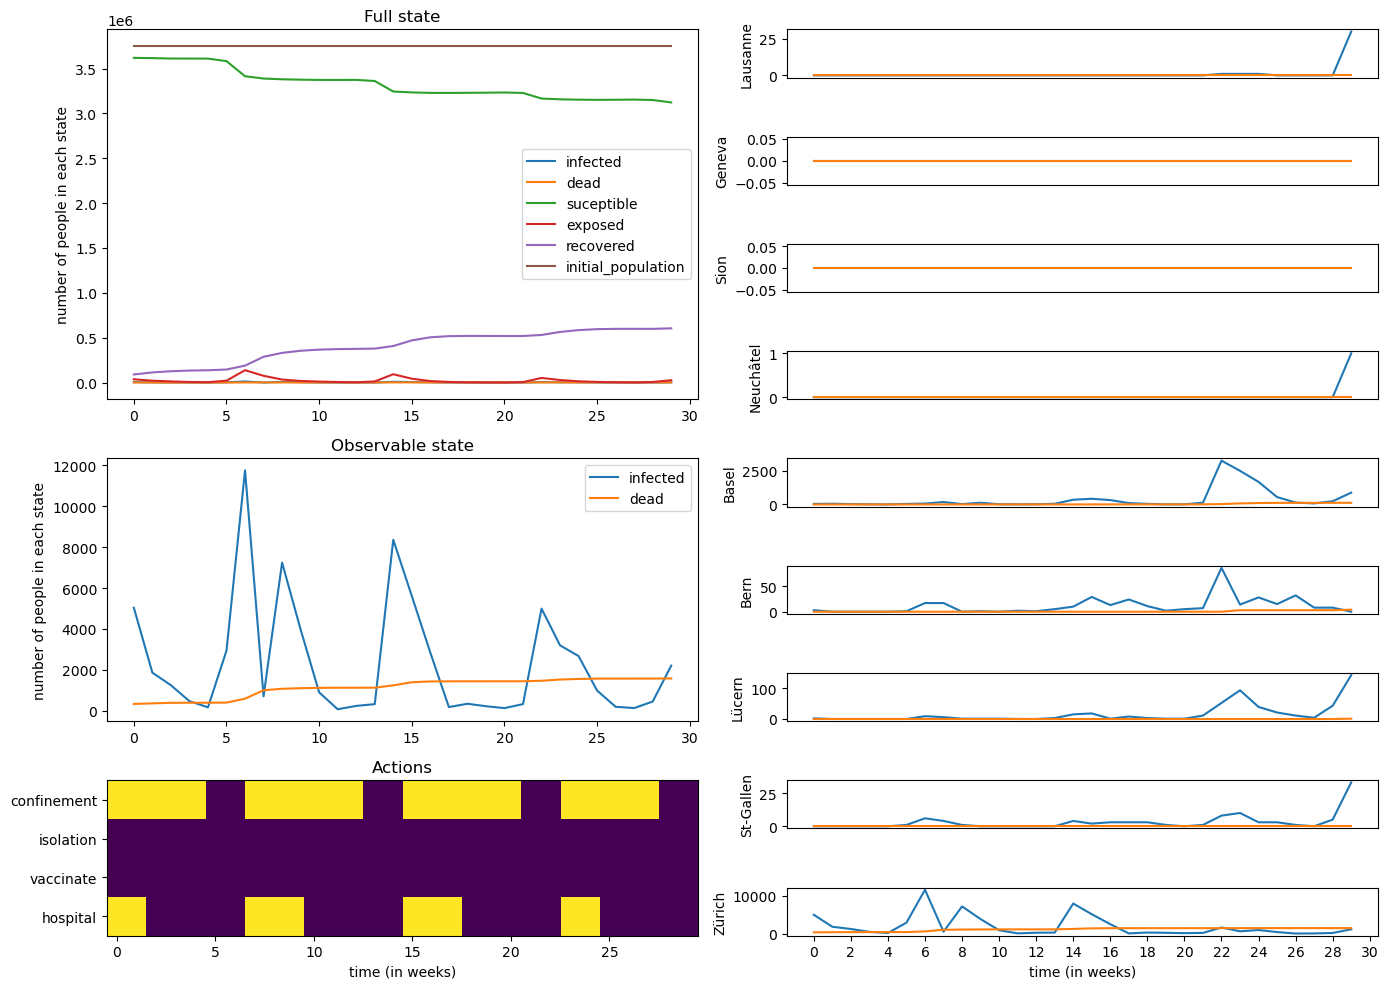

In [76]:
""" Run the simulation 3 times and plot last episode """
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
action_space = spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(dyn, action_space=action_space,
           observation_space=observation_space, 
          action_preprocessor=action_preprocessor_factorized,
          observation_preprocessor=observation_preprocessor)

input_size = dyn.n_cities*2*dyn.env_step_length
# Define the agent
agent = QAgentFactorized(env,device,input_size)
agent.load_model('models/best_model_multi_factorized')

for i in range(3):
    obs , info = env.reset(seed+i)
    log = []
    finished = False
    while not finished:
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        log.append(info) # save the information dict for logging
        
total, cities, actions = parse_logs(dyn, log)
plot_info(total, cities, actions)

##### Question 4.2.b) multi-action factorized Q-values policy evaluation

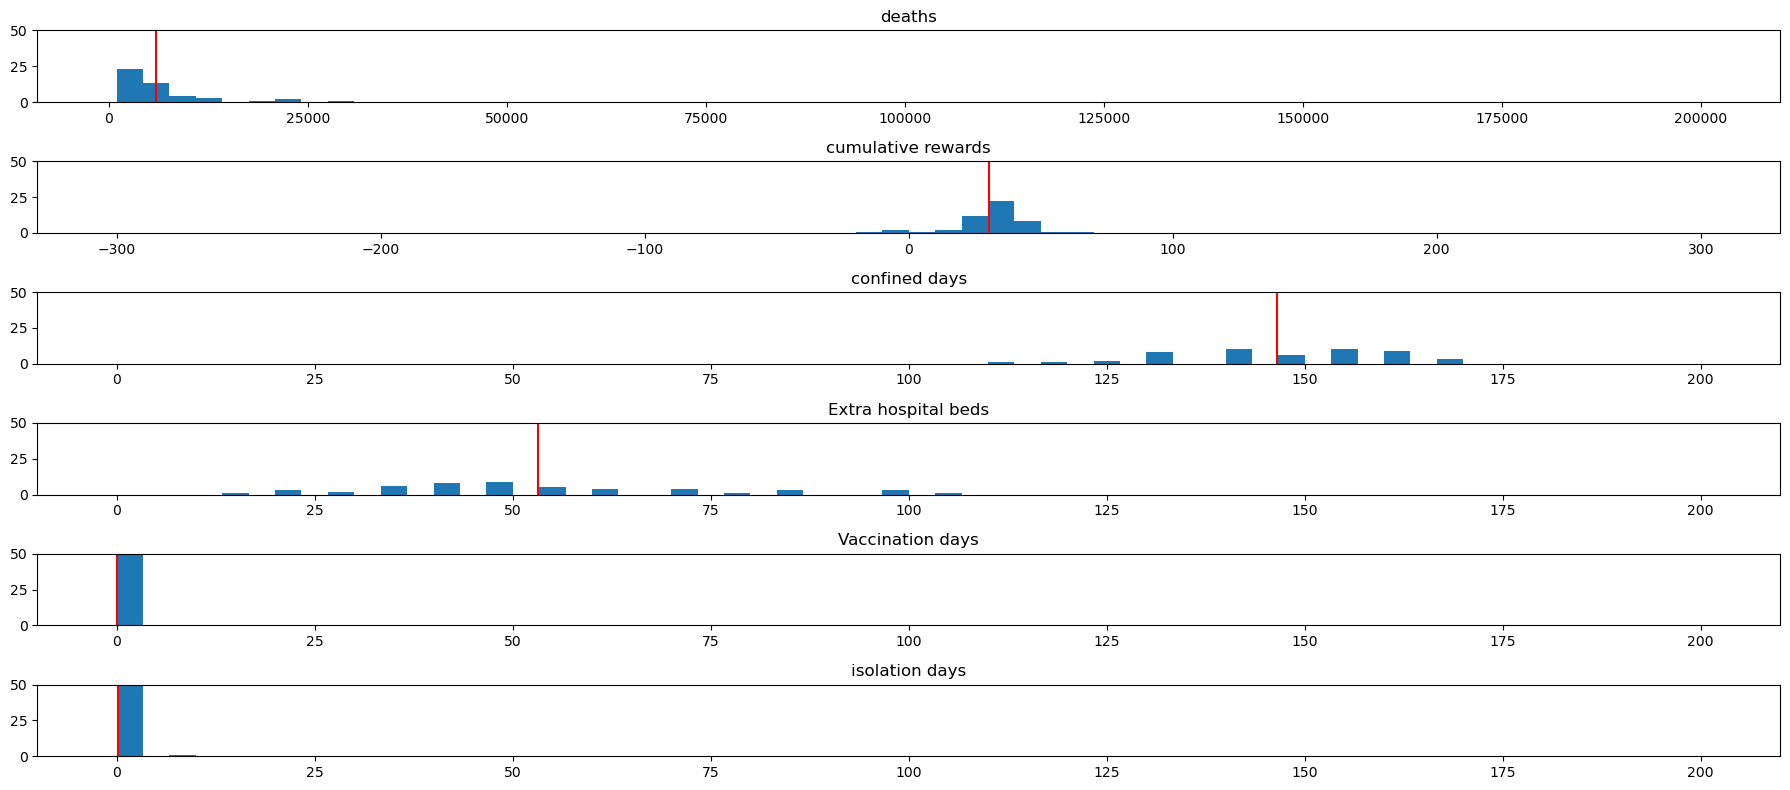

Average death number: 5965.7
Average number of confined days: 146.44
Average cumulative reward: 30.3
Average number of hospitals: 53.2
Average number of vaccines: 0.0
Average number of isolation days: 0.14


In [77]:
""" Run the simulation 3 times and plot last episode """
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map
action_space = spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(dyn, action_space=action_space,
           observation_space=observation_space, 
          action_preprocessor=action_preprocessor_factorized,
          observation_preprocessor=observation_preprocessor)

input_size = dyn.n_cities*2*dyn.env_step_length
# Define the agent
agent = QAgentFactorized(env,device,input_size)
agent.load_model('models/best_model_multi_factorized')

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []
nb_all_hospitals = []
nb_all_vaccinate = []
nb_all_isolation = []

"""Run the simulations, seeded 3 times"""

for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
    for t in range(30):
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
    total, cities, actions = parse_logs(dyn, log)
    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)
    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    # compute the number of hospitals
    nb_hospitals = np.sum(actions['hospital']) * 7
    nb_all_hospitals.append(nb_hospitals)

    # compute the number of vaccines
    nb_vaccinate =np.sum(actions['vaccinate']) * 7
    nb_all_vaccinate.append(nb_vaccinate)

    #compute the number of days in isolation
    nb_isolation = np.sum(actions['isolation']) * 7
    nb_all_isolation.append(nb_isolation)

""" Plot """
fig, ax = plt.subplots(6,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')
hist_avg(ax[3], nb_all_hospitals,'Extra hospital beds')
hist_avg(ax[4], nb_all_vaccinate,'Vaccination days')
hist_avg(ax[5], nb_all_isolation,'isolation days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')
print(f'Average number of hospitals: {np.mean(nb_all_hospitals)}')
print(f'Average number of vaccines: {np.mean(nb_all_vaccinate)}')
print(f'Average number of isolation days: {np.mean(nb_all_isolation)}')

### 5 Wrapping Up

In [129]:
#### load best models 
agent_env_dict = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = dyn.n_cities*2*dyn.env_step_length



#1.load dqn model
action_space  =   spaces.Discrete(2)
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=action_preprocessor,observation_preprocessor=observation_preprocessor)
agent_dqn = QAgent(env,device,input_size)
agent_dqn.load_model('models/best_model_decreasing')
agent_env_dict['dqn'] = (agent_dqn,env)

#2.load factorized model
input_size = dyn.n_cities*2*dyn.env_step_length
action_space = spaces.MultiBinary(4)
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=action_preprocessor_factorized,observation_preprocessor=observation_preprocessor)
agent_dqn_factorized = QAgentFactorized(env,device,input_size)
agent_dqn_factorized.load_model('models/best_model_multi_factorized')
agent_env_dict['factorized'] = (agent_dqn_factorized,env)

#3.load toggle model
input_size = dyn.n_cities*2*dyn.env_step_length+4
action_space = spaces.Discrete(5)
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=action_preprocessor_toggle,observation_preprocessor=observation_preprocessor_action)
agent_dqn_toggle = QAgentMulti(env,device,input_size)
agent_dqn_toggle.load_model('models/best_model_multi')
agent_env_dict['toggle'] = (agent_dqn_toggle,env)


#4.initialize Russo  model
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=action_preprocessor)
agent_russo = Russo(env)
agent_env_dict['russo'] = (agent_russo,env)



In [130]:
# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20


# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_russo = np.zeros((num_traces, num_episodes))
eval_trace_russo = np.zeros((num_traces, num_episodes))


for trace in range(num_traces):
    agent_russo.reset()
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed+episode)
        done = False
        cumulative_reward = 0
    
        while not done:
            action = agent_russo.act(obs, eps=0.0)
            next_obs, R, done, info = env.step(action)
            
            if done:
                next_obs = None
          
            obs = next_obs
            cumulative_reward += int(R)

       
        # Log the cumulative reward to the training trace
        train_trace_russo[trace, episode] = int(cumulative_reward)
        
        
        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                while not done:
                    action = agent_russo.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R

            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)

            if eval_average_reward > best_reward:
                print(' New best model found !')
                agent.save_model(savepath='models/best_model_russo')
                best_reward = eval_average_reward

            
            # Log the evaluation results to the evaluation trace
            eval_trace_russo[trace , episode] = eval_average_reward
            
            print(f"Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")


    
        

Trace 0 Episode: 0, Train Reward: -147.00, Eval Reward: -79.00
Trace 0 Episode: 50, Train Reward: -161.00, Eval Reward: -79.00
Trace 0 Episode: 100, Train Reward: -26.00, Eval Reward: -74.00
Trace 0 Episode: 150, Train Reward: -68.00, Eval Reward: -79.00
Trace 0 Episode: 200, Train Reward: -50.00, Eval Reward: -79.00
Trace 0 Episode: 250, Train Reward: -30.00, Eval Reward: -79.00
Trace 0 Episode: 300, Train Reward: -14.00, Eval Reward: -79.00
Trace 0 Episode: 350, Train Reward: -98.00, Eval Reward: -76.00
Trace 0 Episode: 400, Train Reward: -82.00, Eval Reward: -79.00
Trace 0 Episode: 450, Train Reward: -48.00, Eval Reward: -79.00
Trace 0 Episode: 499, Train Reward: -38.00, Eval Reward: -79.00
Trace 1 Episode: 0, Train Reward: -147.00, Eval Reward: -79.00
Trace 1 Episode: 50, Train Reward: -161.00, Eval Reward: -79.00
Trace 1 Episode: 100, Train Reward: -26.00, Eval Reward: -74.00
Trace 1 Episode: 150, Train Reward: -68.00, Eval Reward: -79.00
Trace 1 Episode: 200, Train Reward: -50.00

#### Question 5.a Comparing the training behaviors

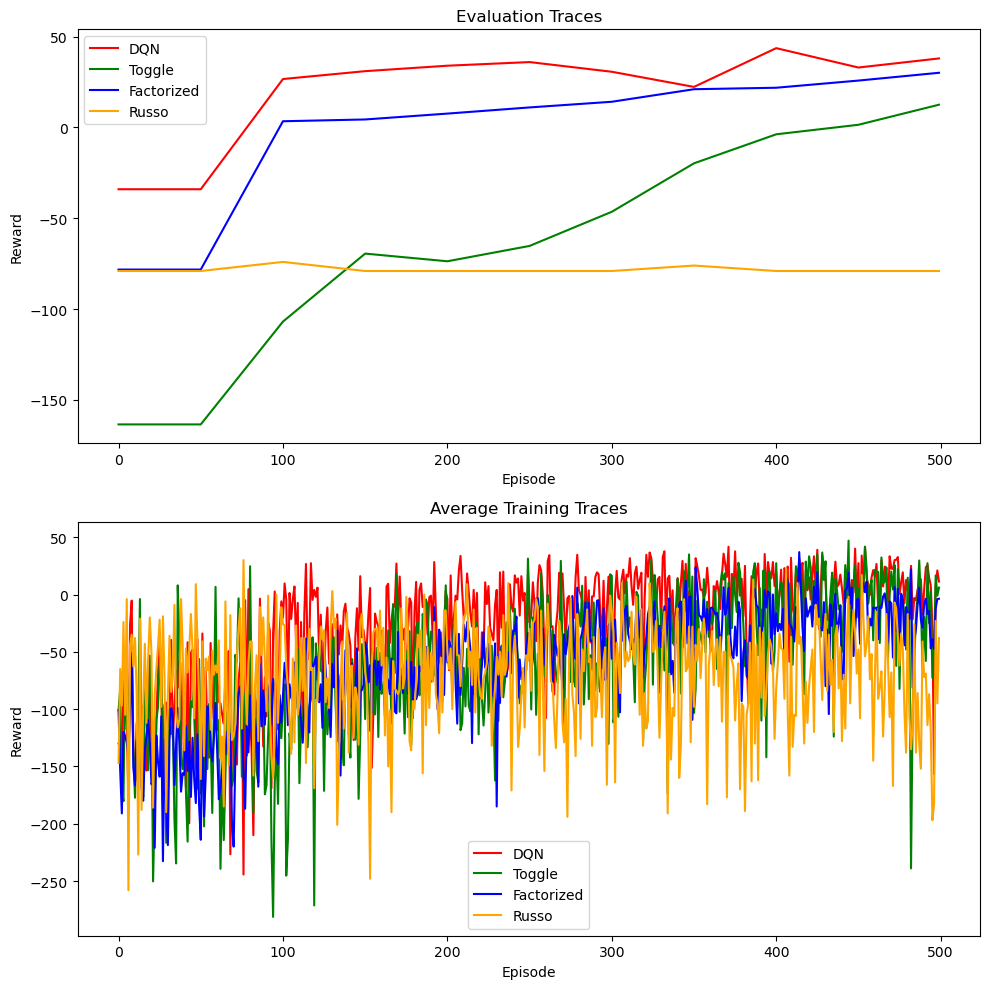

In [135]:
"""Plotting the training and evaluation traces"""
#if you want to plot the traces from the saved files
#eval_trace_russo = np.load('traces/eval_trace_fact.npy')
eval_trace_dqn = np.load('traces/eval_trace_dqn_2.npy')
eval_trace_toggle = np.load('traces/eval_trace_toggle.npy')
eval_trace_fact = np.load('traces/eval_trace_fact.npy')

# load train traces
train_trace_dqn = np.load('traces/train_trace_dqn_2.npy')
train_trace_toggle = np.load('traces/train_trace_toggle.npy')
train_trace_fact = np.load('traces/train_trace_fact.npy')



episodes = np.arange(num_episodes)
# plot evaluation traces
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# replace zeros in the evaluation trace with None
eval_trace_dqn[eval_trace_dqn == 0] = None
avg_eval_trace_dqn = np.mean(eval_trace_dqn,axis=0)
ax1.plot(episodes[~np.isnan(avg_eval_trace_dqn)],avg_eval_trace_dqn[~np.isnan(avg_eval_trace_dqn)],label='DQN',color='red')


# replace zeros in the evaluation trace with None
eval_trace_toggle[eval_trace_toggle == 0] = None
avg_eval_trace_toggle = np.mean(eval_trace_toggle,axis=0)
ax1.plot(episodes[~np.isnan(avg_eval_trace_toggle)],avg_eval_trace_toggle[~np.isnan(avg_eval_trace_toggle)],label='Toggle',color='green')


# replace zeros in the evaluation trace with None
eval_trace_fact[eval_trace_fact == 0] = None
avg_eval_trace_fact = np.mean(eval_trace_fact,axis=0)
ax1.plot(episodes[~np.isnan(avg_eval_trace_fact)],avg_eval_trace_fact[~np.isnan(avg_eval_trace_fact)],label='Factorized',color='blue')


avg_eval_trace_russo = np.mean(eval_trace_russo,axis=0)
ax1.plot(episodes[~np.isnan(avg_eval_trace_fact)],avg_eval_trace_russo[~np.isnan(avg_eval_trace_fact)],label='Russo',color='orange')

ax1.legend()
ax1.set_title('Evaluation Traces')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Reward')

# Calculate the average of training traces
avg_train_trace_dqn = np.mean(train_trace_dqn, axis=0)
avg_train_trace_toggle = np.mean(train_trace_toggle, axis=0)
avg_train_trace_fact = np.mean(train_trace_fact, axis=0)
avg_train_trace_russo = np.mean(train_trace_russo, axis=0)

# Plot average training traces in the second subplot
ax2.plot(episodes, avg_train_trace_dqn, label='DQN', color='red')
ax2.plot(episodes, avg_train_trace_toggle, label='Toggle', color='green')
ax2.plot(episodes, avg_train_trace_fact, label='Factorized', color='blue')
ax2.plot(episodes, avg_train_trace_russo, label='Russo', color='orange')

ax2.legend()
ax2.set_title('Average Training Traces')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Reward')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()





#### Question 5.b Comparing  policies

In [137]:
import pandas as pd
NUM_EPISODES = 50
res = {'russo':{},'dqn':{},'factorized':{},'toggle':{}}

for k, (agent,env) in agent_env_dict.items():
    print(k)
    nb_all_confinement = []
    nb_all_vaccinations = []
    nb_all_hospitalizations = []
    nb_all_deaths = []
    nb_rewards = []
    nb_all_isolation = []
    
    for episode in range(NUM_EPISODES):
        obs, info = env.reset(seed=seed+episode)
        done = False
        cumulative_reward = 0
        log = []
        while not done:
            action = agent.act(obs, eps=0.0)
            obs, R, done, info = env.step(action)
            cumulative_reward += float(R)
            log.append(info)

        total, cities, actions = parse_logs(dyn, log)


        # compute the number of days in confinement
        nb_comfinement = np.sum(actions['confinement']) * 7
        nb_all_confinement.append(nb_comfinement)

        # compute the number of days in isolation
        nb_isolation = np.sum(actions['isolation']) * 7
        nb_all_isolation.append(nb_isolation)

        # compute the number of days  of vaccination
        nb_vac = np.sum(actions['vaccinate']) * 7
        nb_all_vaccinations.append(int(nb_vac))

        # compute the number of days  of hospitalization
        nb_hosp = np.sum(actions['hospital']) * 7
        nb_all_hospitalizations.append(int(nb_hosp))

        # compute the  number of death
      
        nb_death = total['dead'][-1]
        nb_all_deaths.append(int(nb_death))

        # compute the cumulative reward
        nb_rewards.append(cumulative_reward)        


       
    # average number of confined days
    res[k]['avg_confined_days'] = np.mean(nb_all_confinement)

    # average number of isolated days
    res[k]['avg_isolated_days'] = np.mean(nb_all_isolation)

    # average number of vaccinated days
    res[k]['avg_vaccinated_days'] = np.mean(nb_all_vaccinations)

    # average number of hospitalized days
    res[k]['avg_hospitalized_days'] = np.mean(nb_all_hospitalizations)

    # average number of deaths
    res[k]['avg_deaths'] = np.mean(nb_all_deaths)

    # average cumulative reward
    res[k]['avg_rewards'] = np.mean(nb_rewards)



# convert the results to a dataframe
res_df = pd.DataFrame(res).T

res_df


dqn
factorized
toggle
russo


,avg_confined_days,avg_isolated_days,avg_vaccinated_days,avg_hospitalized_days,avg_deaths,avg_rewards
russo,100.24,0.00,0.0,0.00,58071.94,-69.962648
dqn,158.90,0.00,0.0,0.00,2767.10,45.082705
factorized,146.44,0.14,0.0,53.20,5965.70,30.768523
toggle,159.88,0.00,0.0,92.54,8776.22,14.555430


**Question 5.c) (Interpretability) Q-values**

/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/2617811992.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/2617811992.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


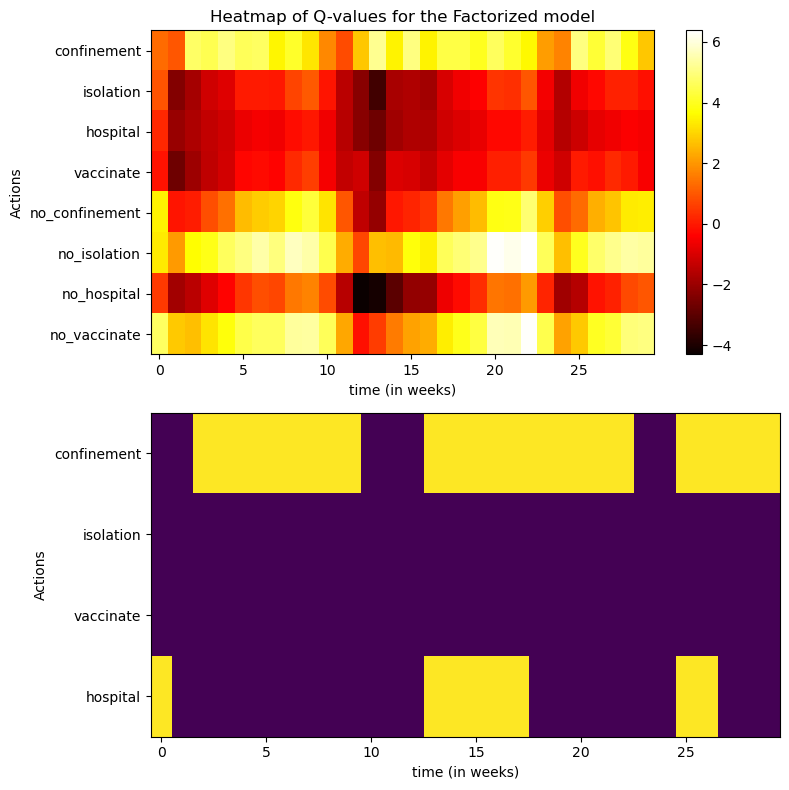

In [ ]:
# Run the simulation for each model and store the episode logs
fig, ax = plt.subplots(2,1,figsize=(8,8))

q_values = []
agent,env = agent_env_dict['factorized'] 
obs, info = env.reset(seed)
log = []
finished = False
while not finished:
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    log.append(info) # save the information dict for logging
    q_value = agent.policy_network(obs.reshape(1, -1)).tolist()[0]
    q_values.append(q_value)
    
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

# Plot the heat map of Q-values
ax[0].imshow(list(map(list, zip(*q_values))), cmap='hot', aspect='auto')
action_set = ['confinement','isolation','hospital','vaccinate','no_confinement','no_isolation','no_hospital','no_vaccinate']
ax[0].set_yticks(np.arange(len(action_set)), action_set)
ax[0].set_title("Heatmap of Q-values for the Factorized model")
ax[0].set_xlabel("time (in weeks)")
ax[0].set_ylabel("Actions")
plt.colorbar(ax[0].imshow(list(map(list, zip(*q_values))), cmap='hot', aspect='auto'))

# Plot the actions
ax[1].imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax[1].set_yticks([0,1,2,3])
ax[1].set_yticklabels(list(actions.keys()))
ax[1].set_xlabel('time (in weeks)')
ax[1].set_ylabel('Actions')

fig.tight_layout()



/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/1968273733.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_34396/1968273733.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)


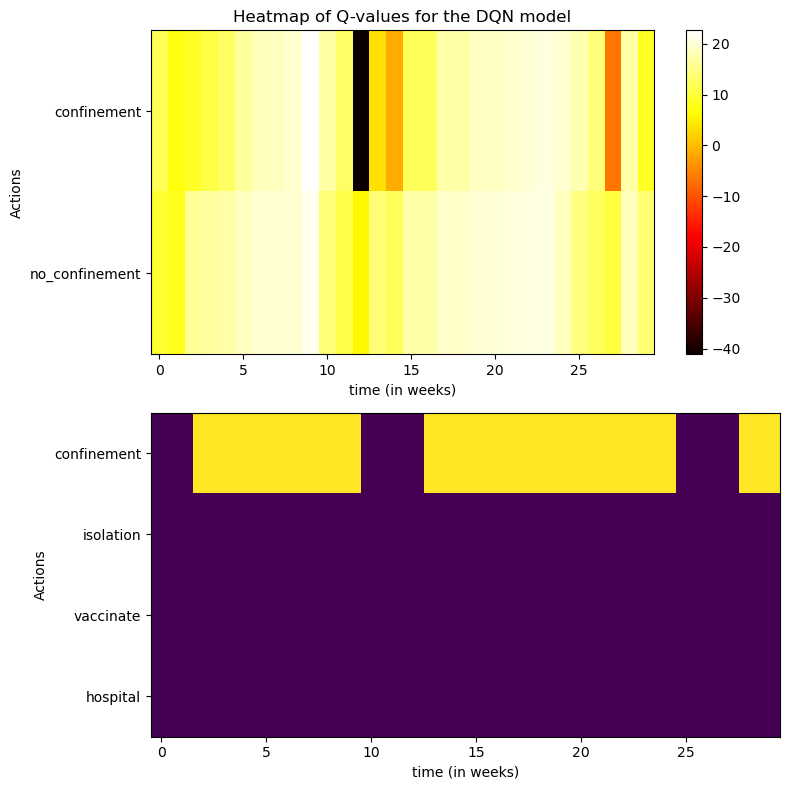

In [141]:
# Run the simulation for each model and store the episode logs
fig, ax = plt.subplots(2,1,figsize=(8,8))
q_values = []
agent,env = agent_env_dict['dqn'] 
obs, info = env.reset(seed)
log = []
finished = False
while not finished:
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
    log.append(info) # save the information dict for logging
    q_value = agent.policy_network(obs.reshape(1, -1)).tolist()[0]
    q_values.append(q_value)
    
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

# Plot the heat map of Q-values
ax[0].imshow(list(map(list, zip(*q_values))), cmap='hot', aspect='auto')
action_set = ['confinement','no_confinement']
ax[0].set_yticks(np.arange(len(action_set)), action_set)
ax[0].set_title("Heatmap of Q-values for the DQN model")
ax[0].set_xlabel("time (in weeks)")
ax[0].set_ylabel("Actions")
plt.colorbar(ax[0].imshow(list(map(list, zip(*q_values))), cmap='hot', aspect='auto'))

# Plot the actions
# ax[1].imshow([actions['confinement'].astype(np.uint8)],aspect='auto')
# ax[1].set_yticks([0])
# ax[1].set_yticklabels(['confinement'])
# ax[1].set_xlabel('time (in weeks)')
# ax[1].set_ylabel('Actions')
ax[1].imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax[1].set_yticks([0,1,2,3])
ax[1].set_yticklabels(list(actions.keys()))
ax[1].set_xlabel('time (in weeks)')
ax[1].set_ylabel('Actions')

fig.tight_layout()

